In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

### Import Libraries and Modules: 
This cell imports various necessary libraries and modules. 

matplotlib.pyplot is used for plotting, 
numpy for numerical array operations, 
pandas for data manipulation and analysis, 
random for random number generation, and 
torch along with torchvision for deep learning tasks. 

Specific modules from torch such as DataLoader, random_split, nn (neural network), functional, and optim are also imported.

### Data Loading and Transformation

In this cell, the MNIST dataset is loaded using `torchvision.datasets.MNIST`. <br/>
The dataset is divided into training and test sets. <br/>
Transformations such as `transforms.ToTensor()` are applied to both training and test datasets.<br/> 
The training dataset is further split into training and validation sets,<br/> 
and `DataLoader` instances are created for each of these sets with a specified batch size.

In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


100%|█████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 19538927.38it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 59702165.51it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


100%|█████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 19309987.68it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 13211185.00it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Definition of the Variational Encoder Class


This cell defines a class `VariationalEncoder`, which inherits from `torch.nn.Module`. <br\>
The class is designed to implement a variational autoencoder. It initializes convolutional and linear layers, batch normalization, and sets up a normal distribution for sampling. <br\>

The `forward` method defines the forward pass of the network, computing the mean (`mu`) and standard deviation (`sigma`) of the latent space, and then sampling from this space using the reparameterization trick.

### Class Initialization (`__init__` method):
**Purpose:** To initialize the encoder part of a Variational Autoencoder.

**Parameters:**
`latent_dims`: The dimensionality of the latent space representation.

**Components:**
* Convolutional Layers (`conv1`, `conv2`, `conv3`): These layers are used to progressively extract features from the input images. The input and output channels, kernel sizes, stride, and padding are specified for each convolutional layer.

* Batch Normalization (`batch2`): Applied after the second convolutional layer to stabilize and speed up learning.

* Linear Layers (`linear1`, `linear2`, `linear3`): After flattening the output of the convolutional layers, these linear layers are used to generate parameters for the latent space distribution — mean (`mu`) and standard deviation (`sigma`).

* Normal Distribution (`self.N`): A standard normal distribution used for sampling in the latent space. It's configured to operate on GPU for efficiency.

* KL Divergence (`self.kl`): Initialized to zero, this will be used to calculate the Kullback-Leibler divergence during the forward pass, which is a component of the VAE loss function.


### Forward Pass (`forward` method):
**Purpose:** To define the computation performed at every call. Specifically, it encodes input data into a latent space representation.

**Input:**
* `x`: The input tensor (e.g., an image).

**Process:**
* The input `x` is first passed through the convolutional layers with ReLU activations.
* It is then flattened and passed through a linear layer (`linear1`) with a ReLU activation.
* Two separate linear layers (`linear2` and `linear3`) compute the mean (`mu`) and log variance (`sigma`) of the latent space representation.
* A latent code `z` is sampled from a normal distribution centered at `mu` with standard deviation `exp(sigma)`, using the reparameterization trick.
* The KL divergence (`self.kl`) is computed, which is a measure of how much information is lost when using the approximate posterior (the encoder's output) instead of the true posterior.

**Output:**
`z`: The latent representation of the input data.

**Key Characteristics:**
**Variational Aspect:** The encoder does not output a fixed vector in the latent space but parameters of a probability distribution, from which a latent vector is sampled.

**Usage in Training:** During training, the KL divergence is used as a part of the loss function to ensure that the distribution of the latent space resembles a standard normal distribution.

This class is essential for learning compact and efficient representations in a VAE framework, and is typically paired with a corresponding decoder to form a complete VAE model.

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

### Definition of the Decoder Class


This cell defines a class `Decoder`, which is also a subclass of `torch.nn.Module`. 

This class is likely to be responsible for constructing the decoder part of an autoencoder architecture. The initial part of the code defines the class constructor and initializes various layers and operations.

### Class Initialization (__init__ method):
* **Purpose:** To initialize the decoder part of a Variational Autoencoder.

* **Parameters:**
* latent_dims: The dimensionality of the latent space from which the decoder reconstructs the input.

* **Components:**
* Linear Sequential Layers (`decoder_lin`):
    * Comprises two linear layers, each followed by a ReLU (Rectified Linear Unit) activation function.
    * These layers gradually upscale the latent vector to a higher dimension that matches the flattened shape of the original input.
* Unflatten Layer (`unflatten`):
    * Transforms the output of the linear layers back into a 3-dimensional tensor, preparing it for the convolutional transpose layers.
    * The target size is set to match the expected input shape of the first convolutional transpose layer.
* Convolutional Transpose Sequential Layers (`decoder_conv`):
    * Contains three sets of convolutional transpose layers, each followed by batch normalization and ReLU activation, except for the last layer.
    * These layers incrementally upscale the feature map to reconstruct the original input size.
    * The final layer reduces the channel size to match the original input's channel size.


### Forward Pass (forward method):
* **Purpose:** To define the computation performed at every call, reconstructing the input from its encoded latent representation.

* **Input:**
* `x`: The latent representation vector.

* **Process:**
* The latent vector `x` is first passed through the linear sequential layers (`decoder_lin`), followed by the unflatten operation.
* The resulting tensor is then processed through the convolutional transpose layers (`decoder_conv`).
* A sigmoid activation function is applied to the output to normalize the pixel values (typically to a range of [0, 1]).

* **Output:**
* The reconstructed input, typically an image, with the same dimensions as the original input.


### Key Characteristics:
* **Upscaling:** The decoder performs the opposite operation of the encoder, gradually upscaling the compressed representation back to the original input size.
* **Reconstruction:** It aims to reconstruct the input data as accurately as possible from the latent representation.
* **Use in VAE:** In a VAE, the quality of reconstruction, along with the divergence from a standard normal distribution in the latent space (computed in the encoder), forms the basis of the loss function used for training.

The `Decoder` class plays a crucial role in learning the data generation process in a VAE, aiming to produce outputs that are as close as possible to the original inputs, given their latent representations.

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

### Definition of the Variational Autoencoder Class


This cell defines a class `VariationalAutoencoder`, inheriting from `torch.nn.Module`. 


This class is expected to encapsulate the complete variational autoencoder architecture, integrating both the encoder and decoder components defined in the previous cells.

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Setting Up the Autoencoder and Random Seed


This cell includes code to set a random seed for reproducibility of results using `torch.manual_seed`. 


It also appears to instantiate the `VariationalAutoencoder` class with a specific dimension for the latent space.

In [6]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [18]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [19]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [20]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


 EPOCH 1/100 	 train loss 31.872 	 val loss 32.293


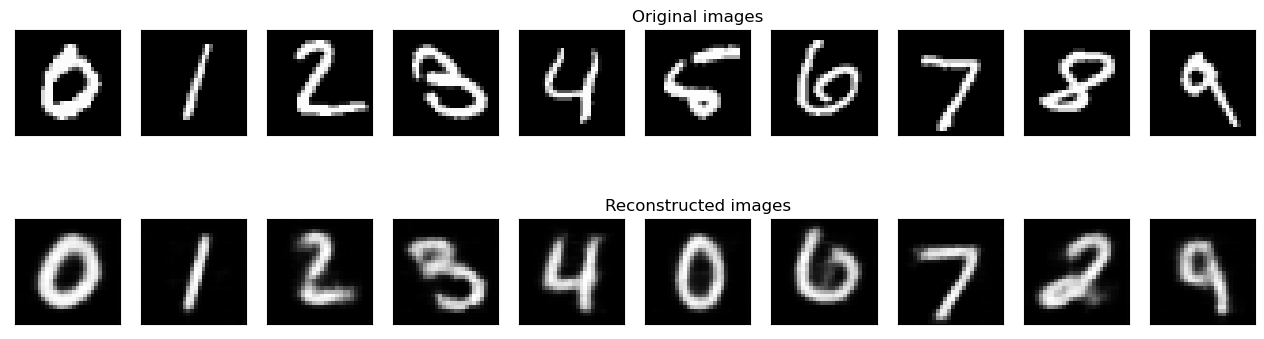


 EPOCH 2/100 	 train loss 31.845 	 val loss 32.374


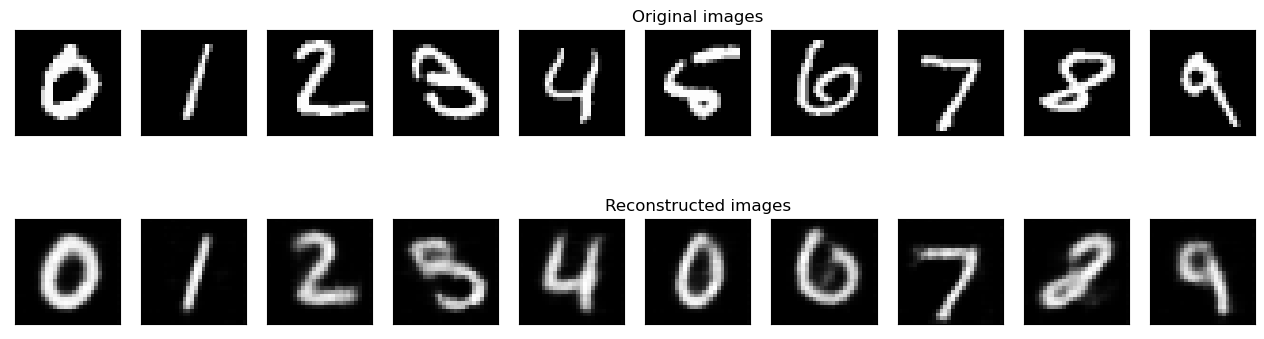


 EPOCH 3/100 	 train loss 31.830 	 val loss 32.349


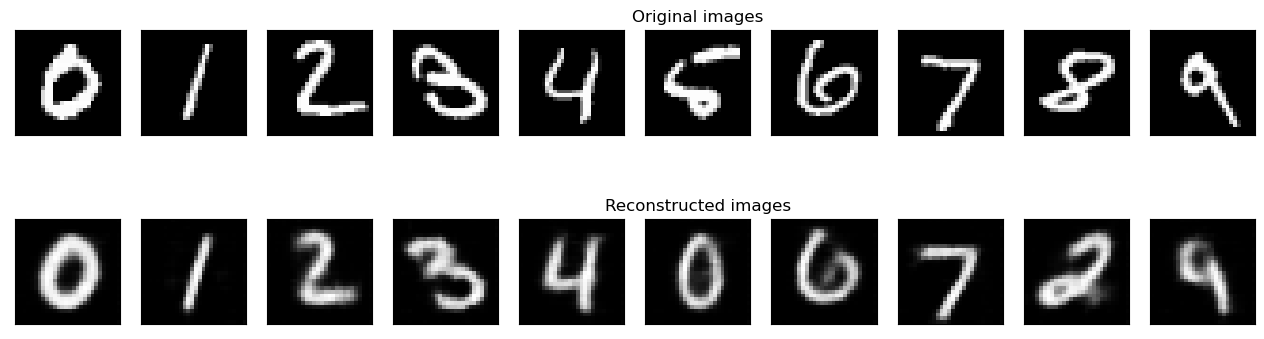


 EPOCH 4/100 	 train loss 31.834 	 val loss 32.415


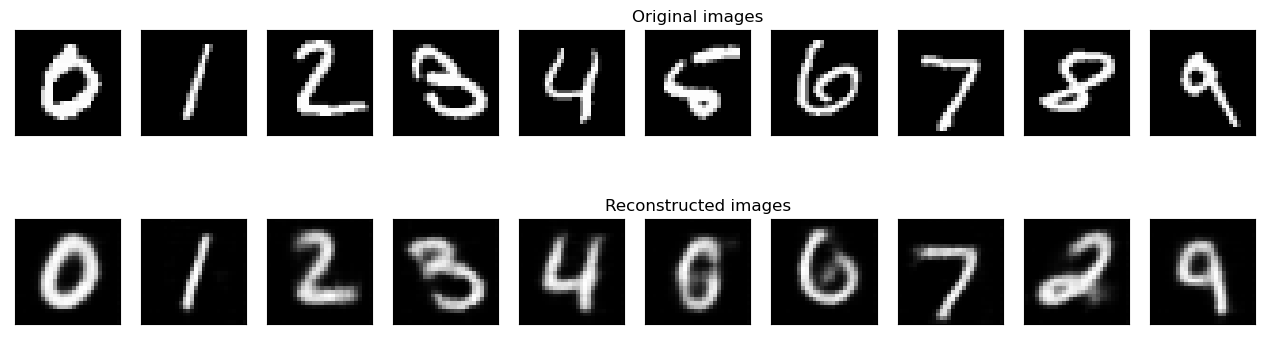


 EPOCH 5/100 	 train loss 31.815 	 val loss 32.254


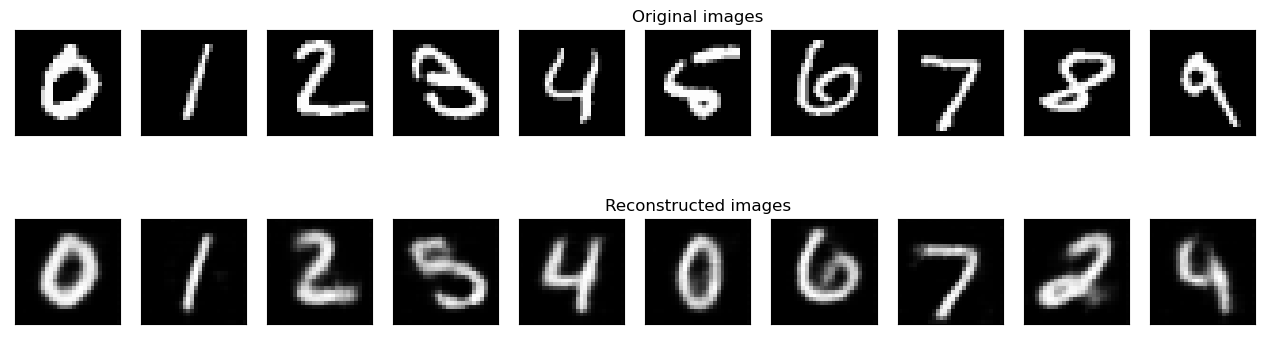


 EPOCH 6/100 	 train loss 31.780 	 val loss 32.206


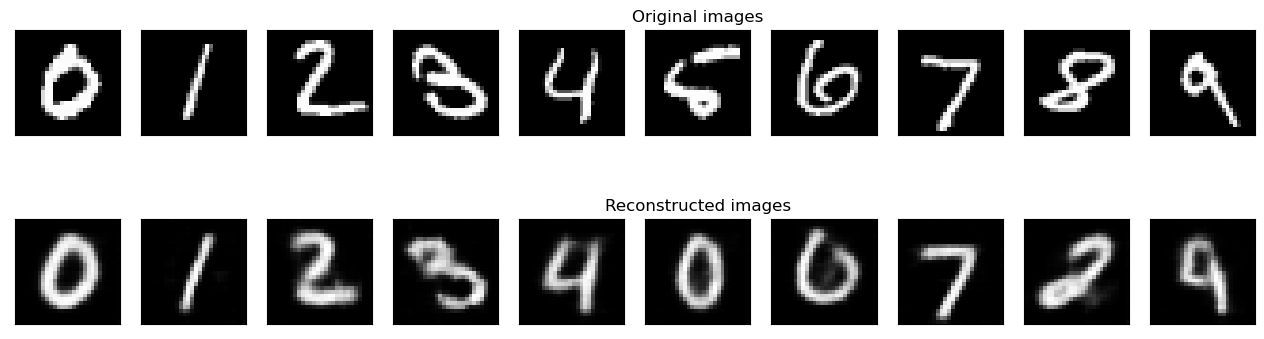


 EPOCH 7/100 	 train loss 31.755 	 val loss 32.319


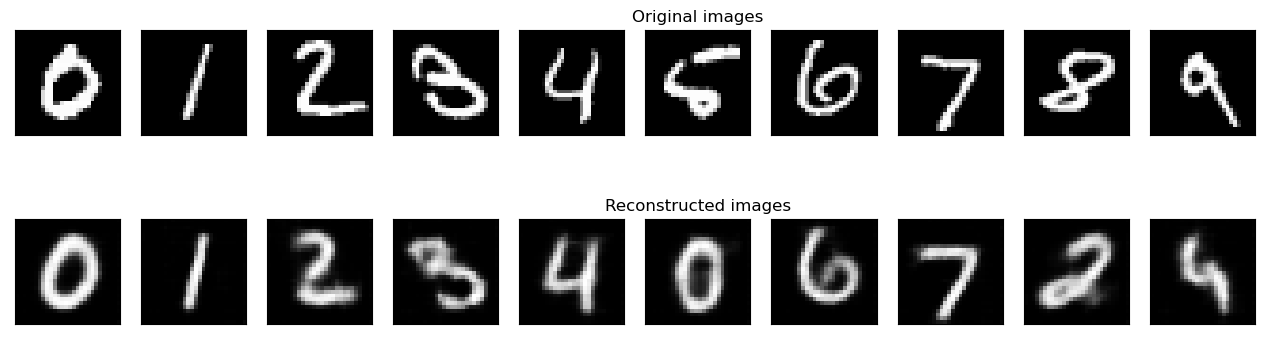


 EPOCH 8/100 	 train loss 31.743 	 val loss 32.249


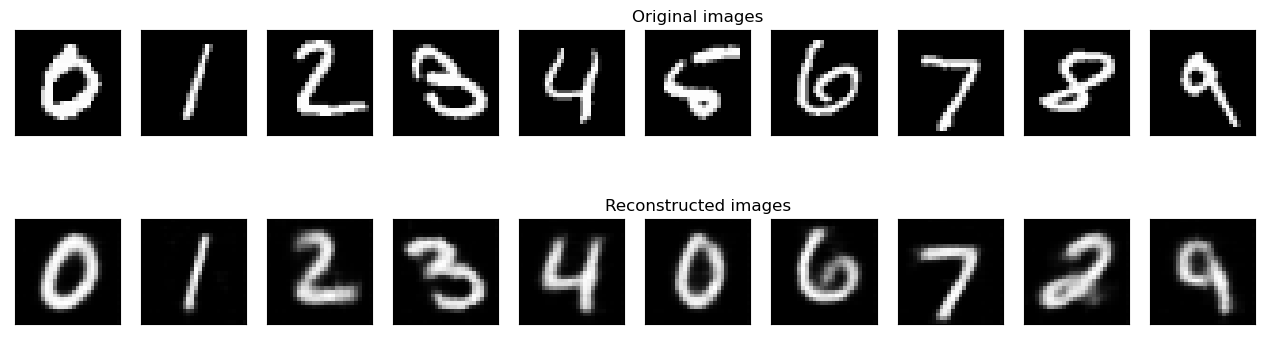


 EPOCH 9/100 	 train loss 31.742 	 val loss 32.232


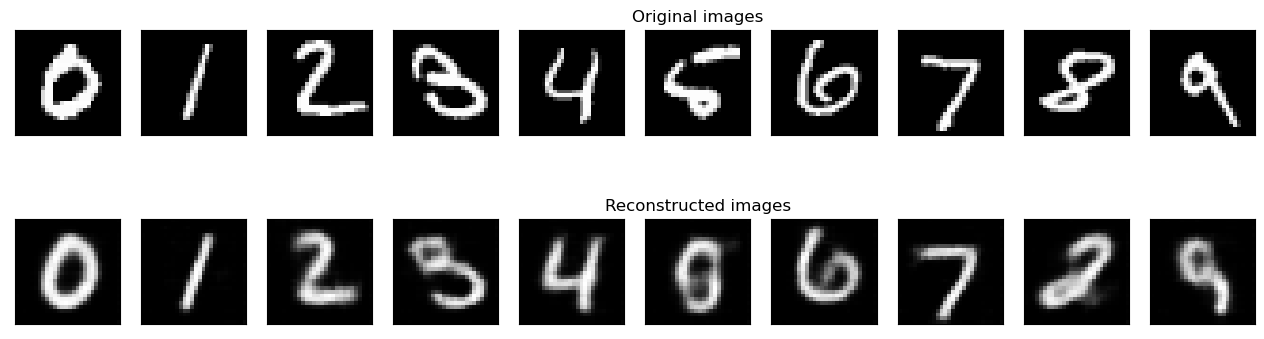


 EPOCH 10/100 	 train loss 31.709 	 val loss 32.217


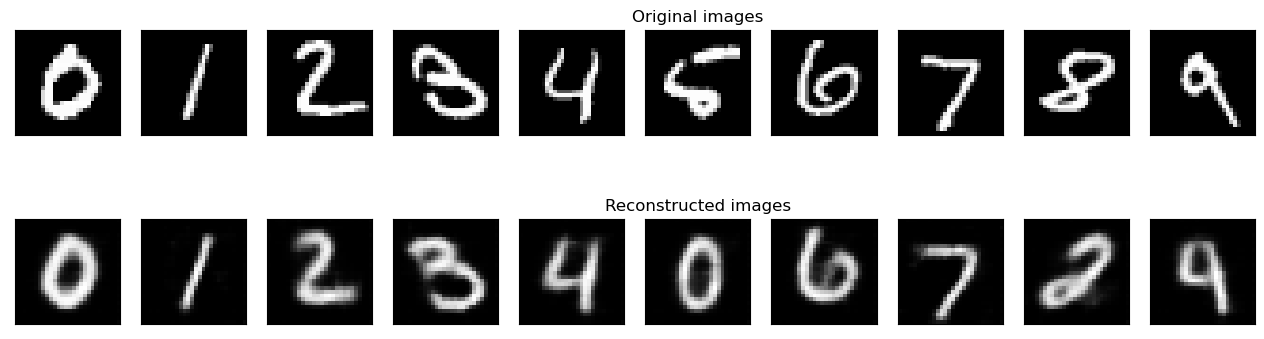


 EPOCH 11/100 	 train loss 31.718 	 val loss 32.351


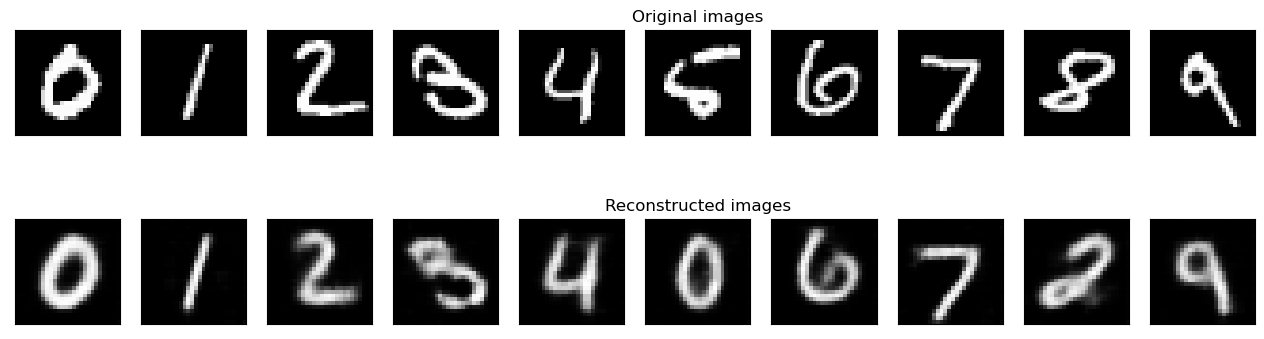


 EPOCH 12/100 	 train loss 31.697 	 val loss 32.179


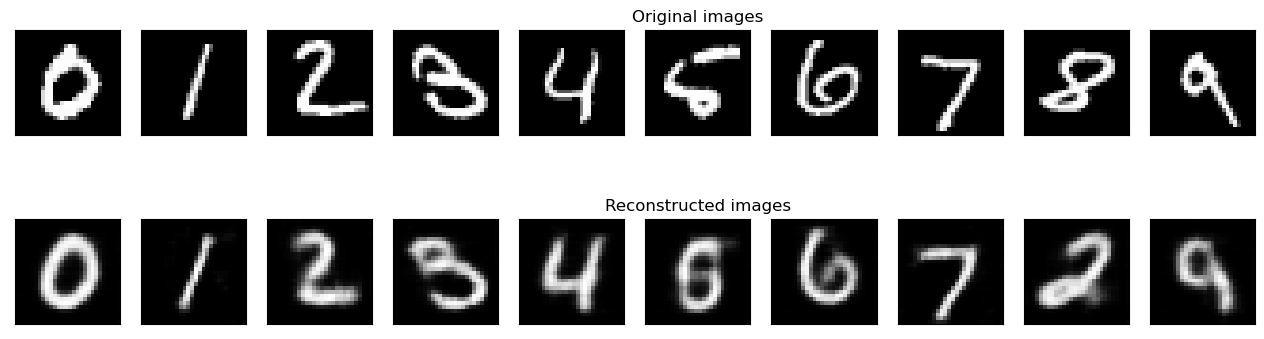


 EPOCH 13/100 	 train loss 31.659 	 val loss 32.124


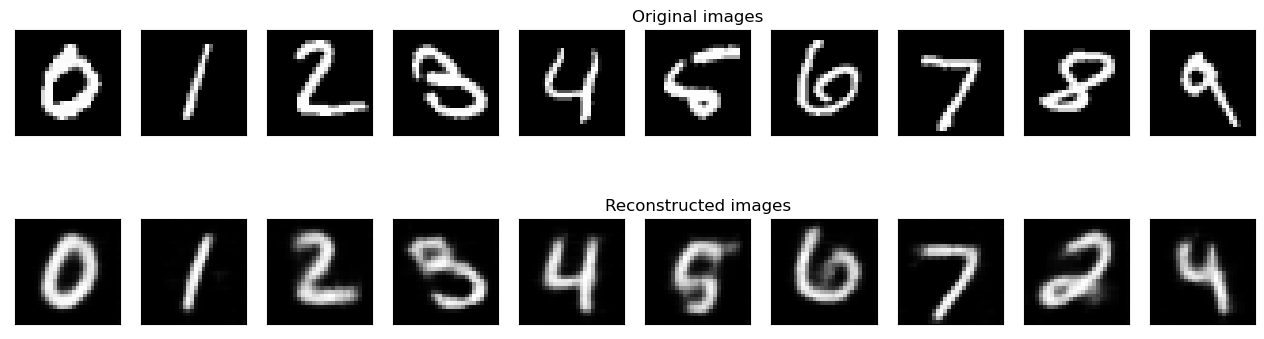


 EPOCH 14/100 	 train loss 31.671 	 val loss 32.182


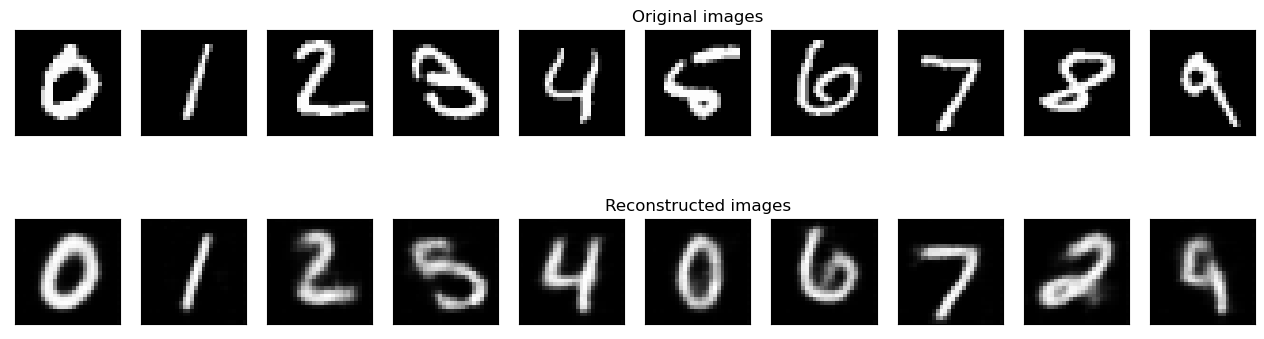


 EPOCH 15/100 	 train loss 31.664 	 val loss 32.125


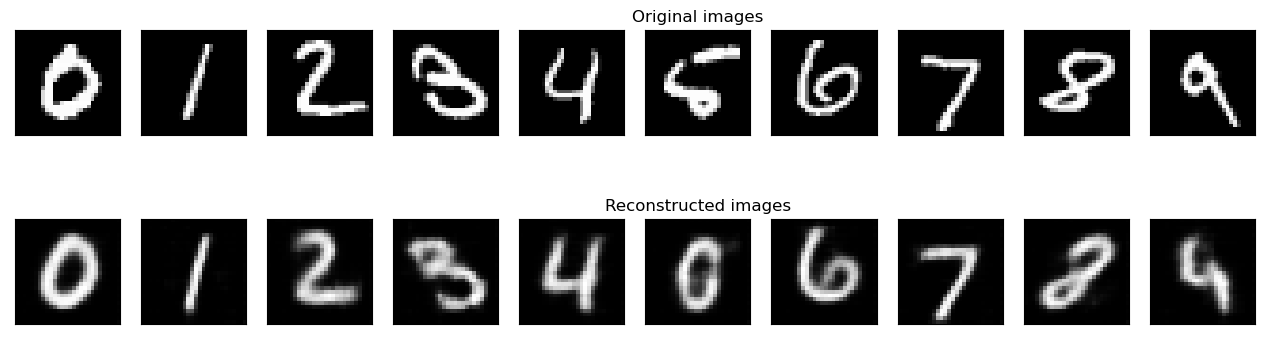


 EPOCH 16/100 	 train loss 31.633 	 val loss 32.152


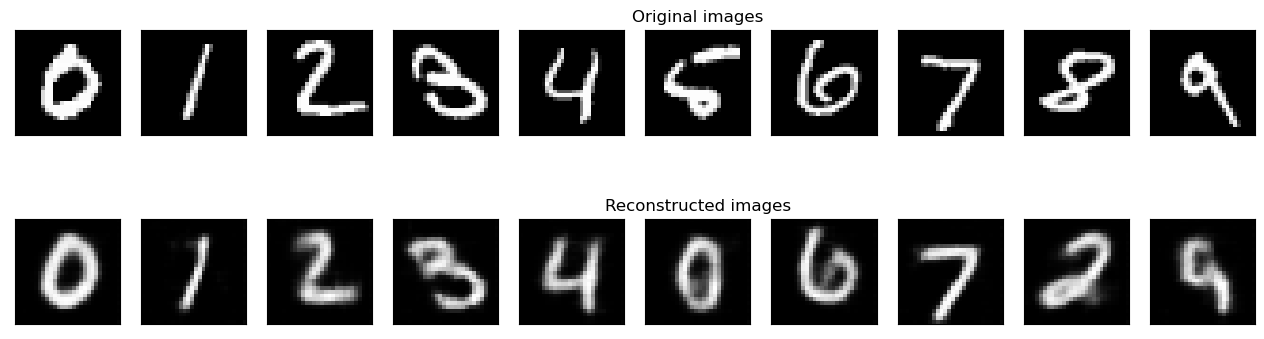


 EPOCH 17/100 	 train loss 31.597 	 val loss 32.068


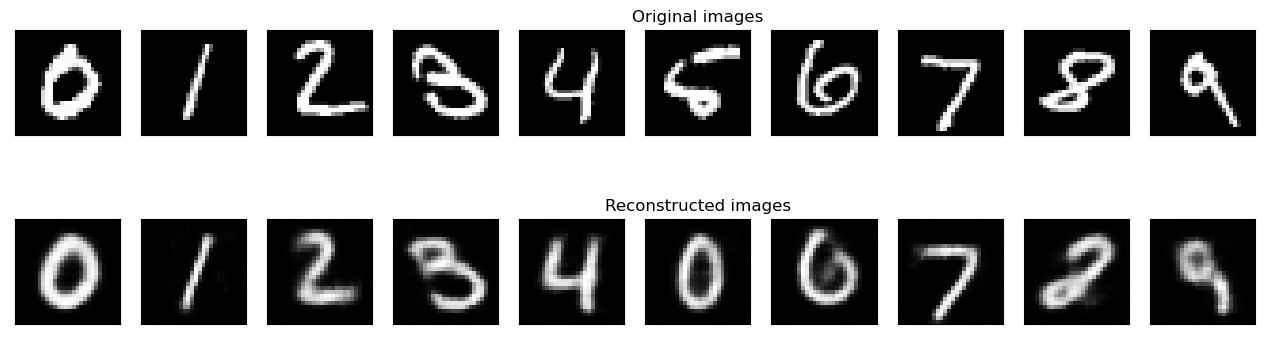


 EPOCH 18/100 	 train loss 31.591 	 val loss 32.231


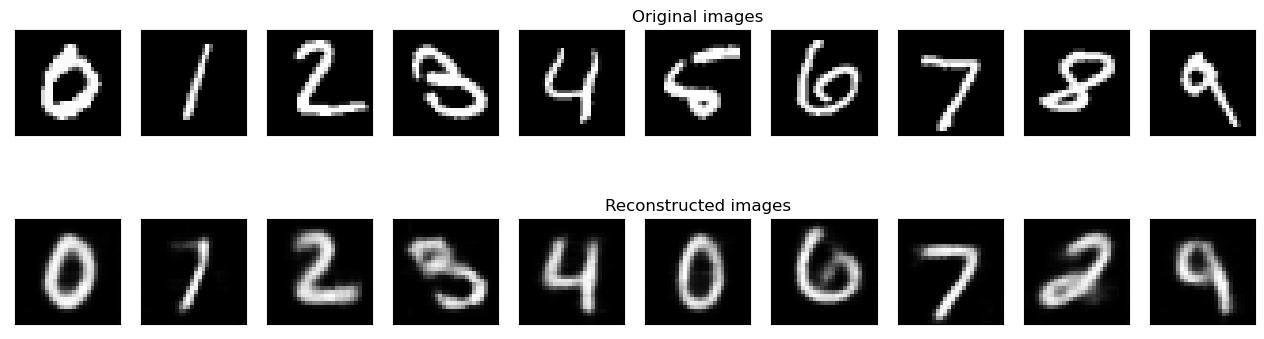


 EPOCH 19/100 	 train loss 31.599 	 val loss 32.136


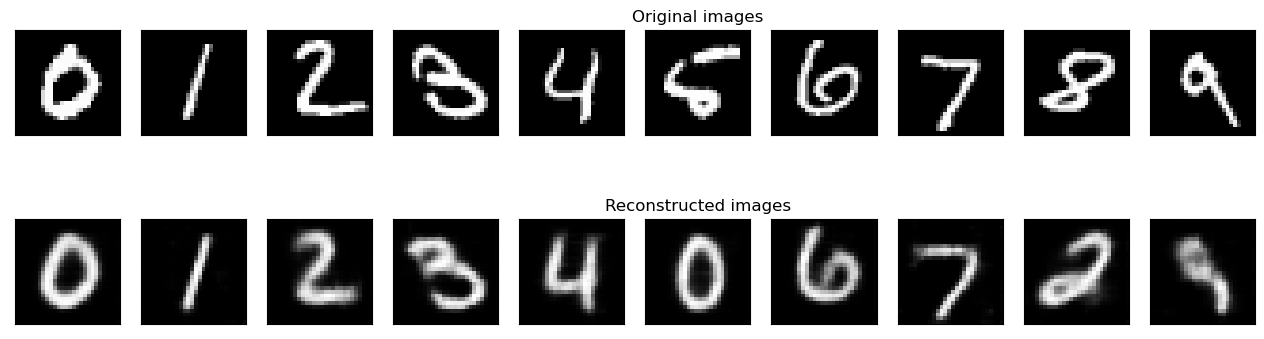


 EPOCH 20/100 	 train loss 31.595 	 val loss 32.132


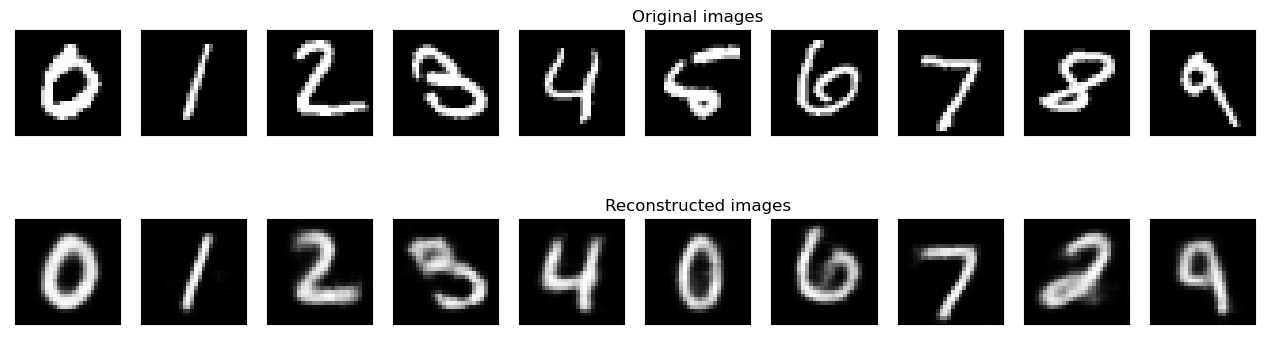


 EPOCH 21/100 	 train loss 31.564 	 val loss 32.144


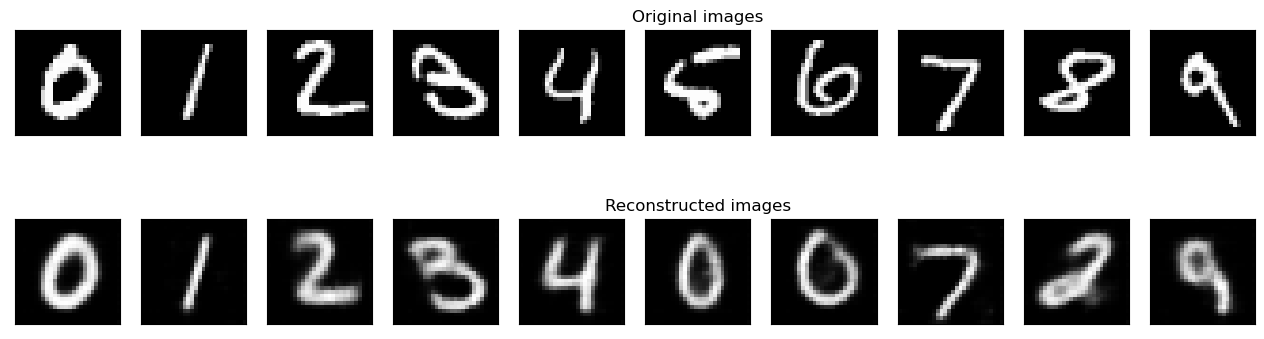


 EPOCH 22/100 	 train loss 31.554 	 val loss 32.099


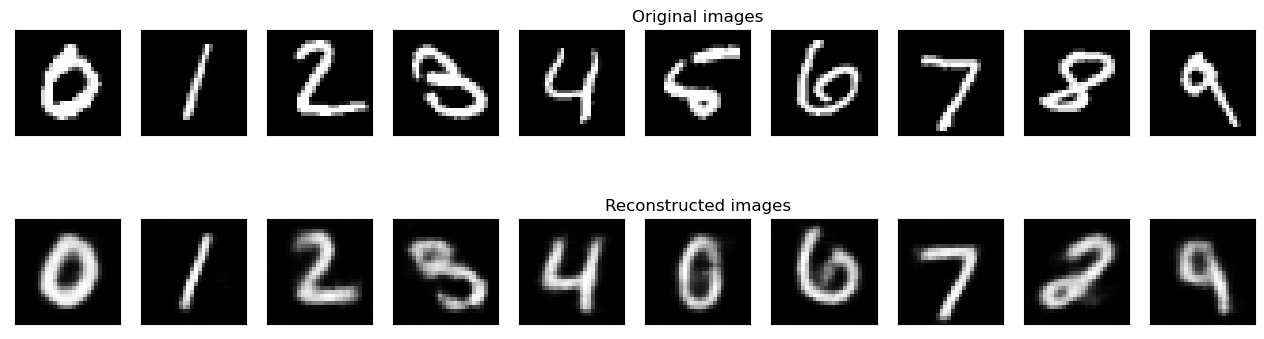


 EPOCH 23/100 	 train loss 31.544 	 val loss 32.097


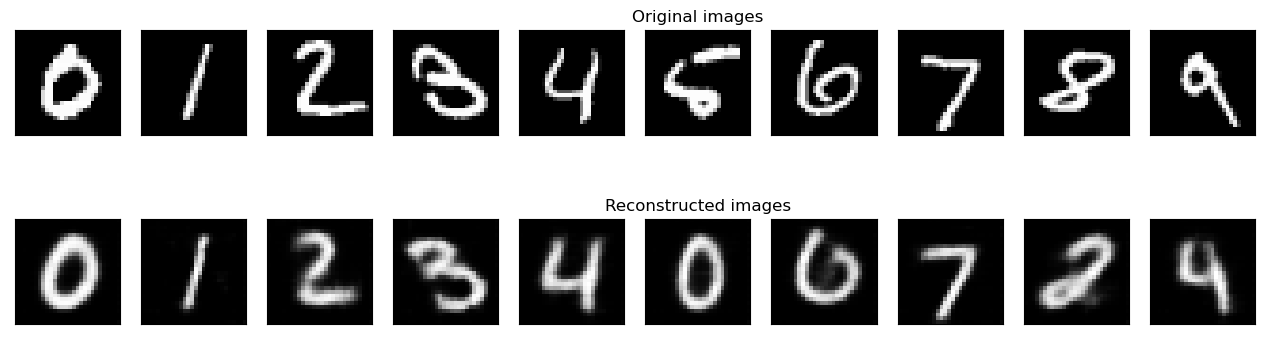


 EPOCH 24/100 	 train loss 31.510 	 val loss 32.119


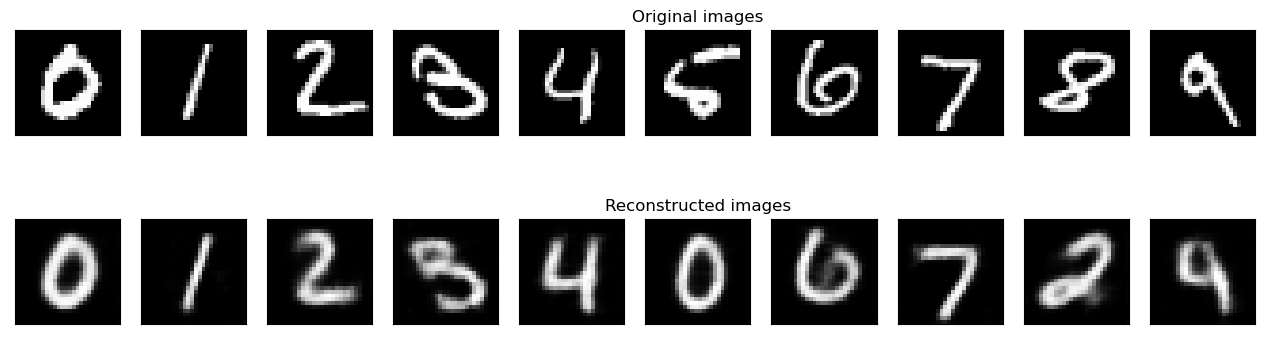


 EPOCH 25/100 	 train loss 31.503 	 val loss 32.171


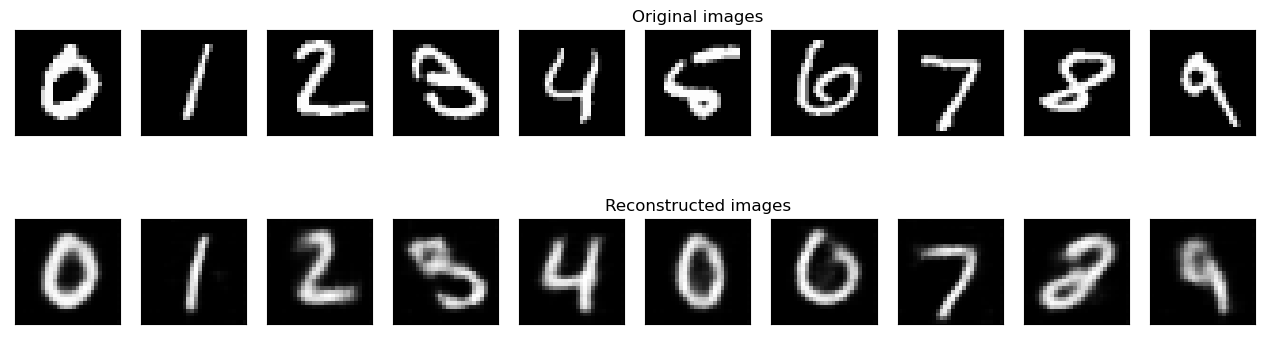


 EPOCH 26/100 	 train loss 31.499 	 val loss 32.094


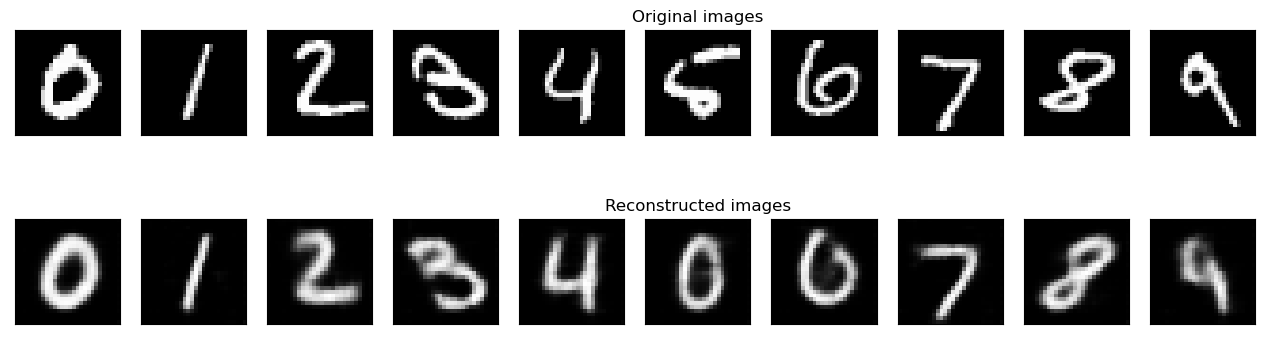


 EPOCH 27/100 	 train loss 31.485 	 val loss 32.046


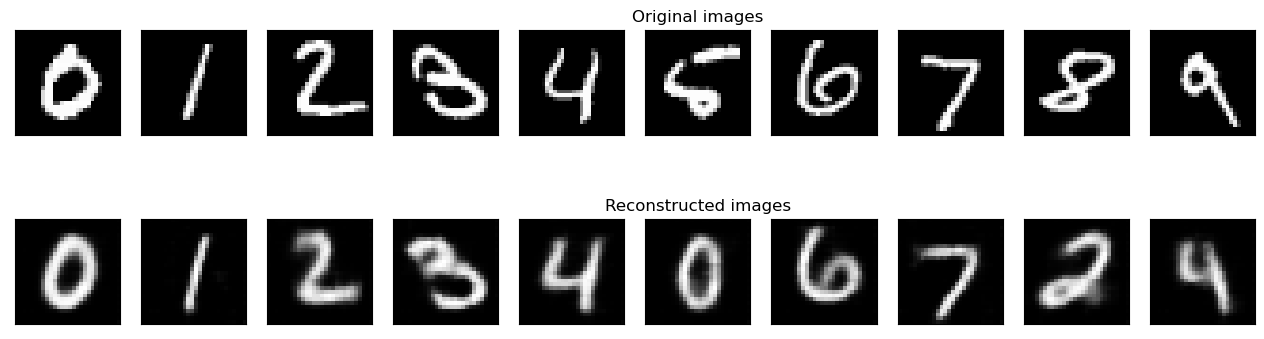


 EPOCH 28/100 	 train loss 31.487 	 val loss 32.041


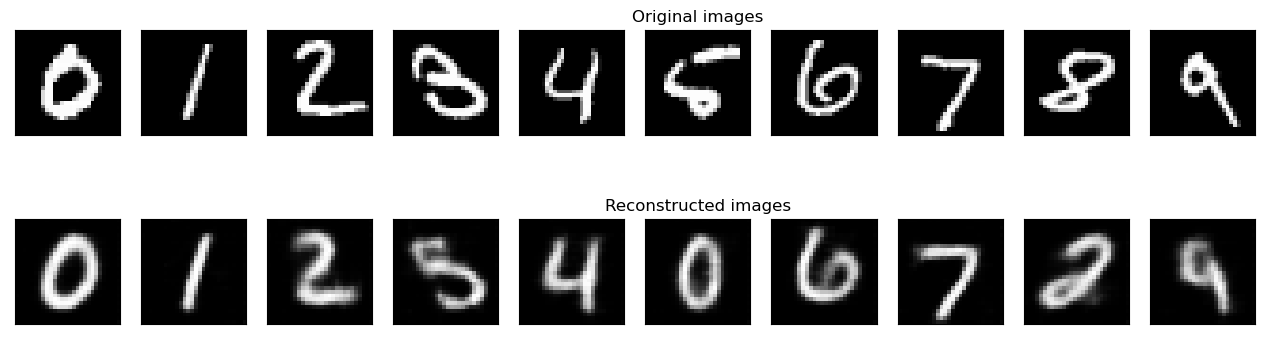


 EPOCH 29/100 	 train loss 31.476 	 val loss 32.029


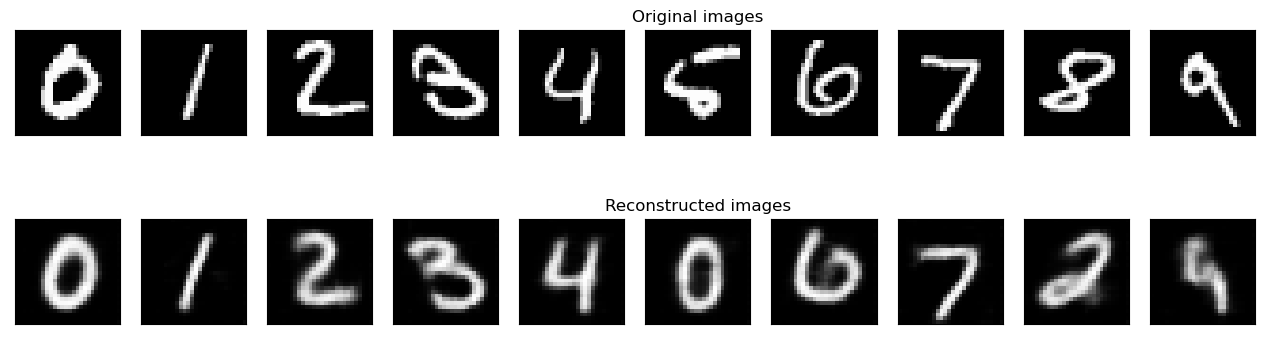


 EPOCH 30/100 	 train loss 31.482 	 val loss 32.030


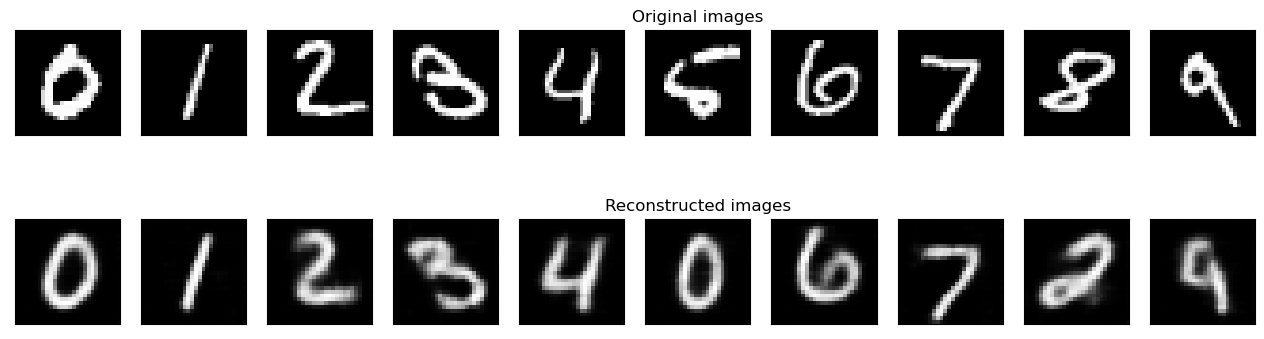


 EPOCH 31/100 	 train loss 31.457 	 val loss 32.098


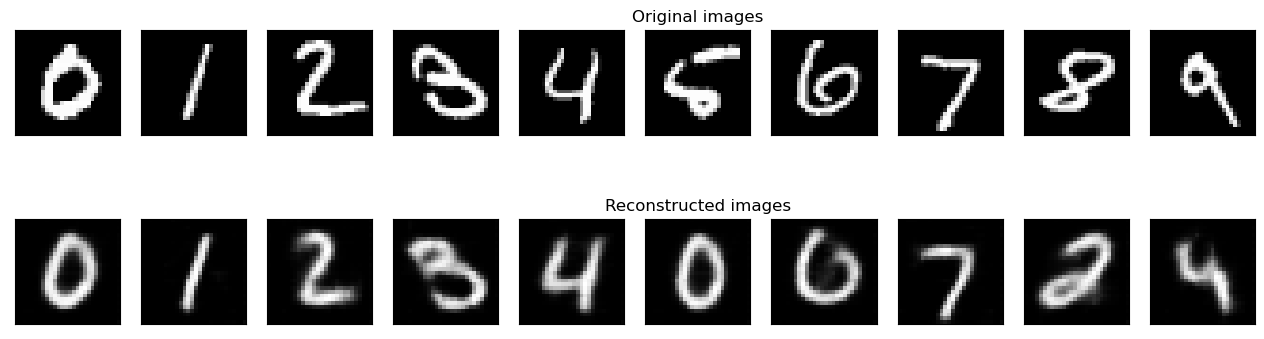


 EPOCH 32/100 	 train loss 31.453 	 val loss 32.054


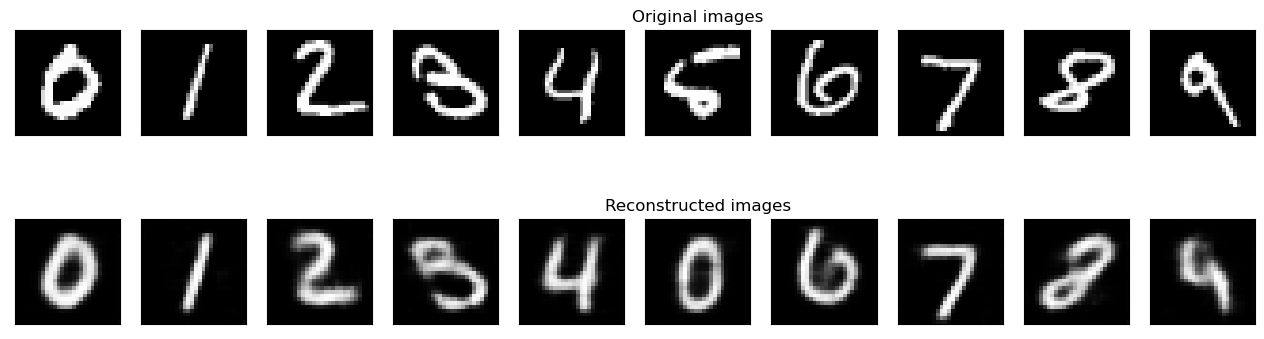


 EPOCH 33/100 	 train loss 31.429 	 val loss 31.998


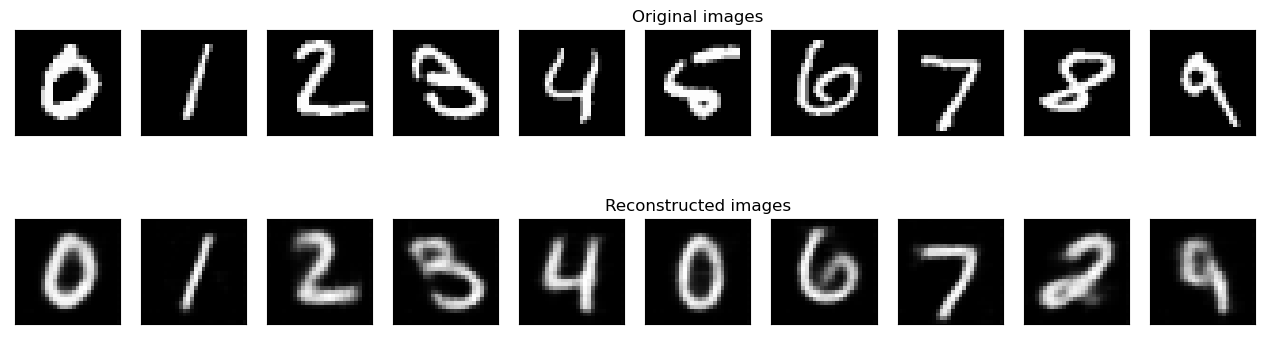


 EPOCH 34/100 	 train loss 31.403 	 val loss 32.073


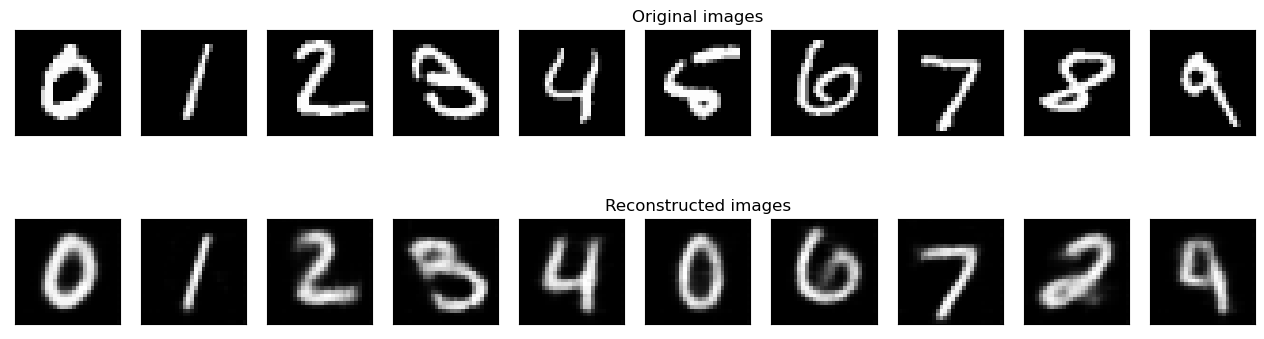


 EPOCH 35/100 	 train loss 31.409 	 val loss 32.101


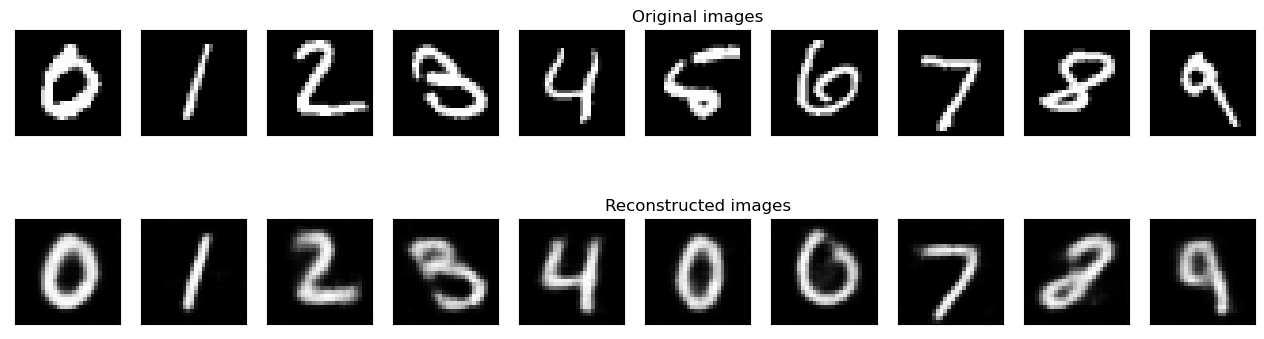


 EPOCH 36/100 	 train loss 31.403 	 val loss 32.023


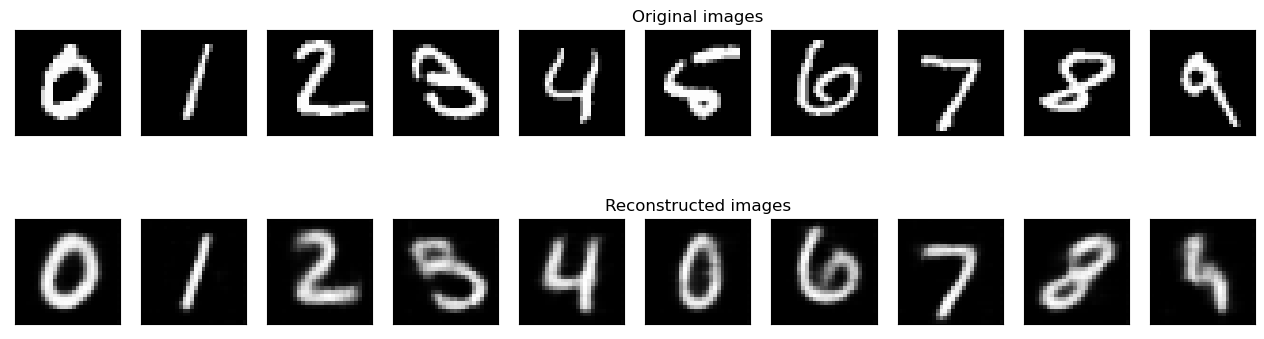


 EPOCH 37/100 	 train loss 31.405 	 val loss 32.058


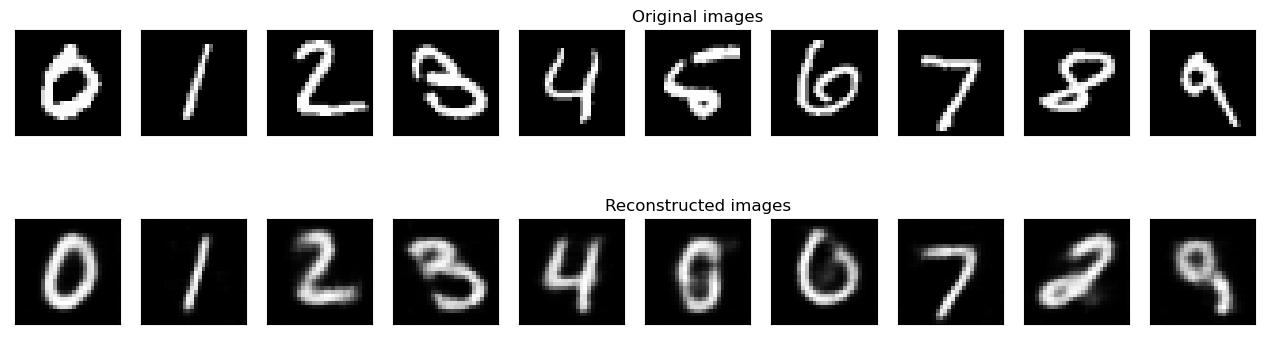


 EPOCH 38/100 	 train loss 31.382 	 val loss 32.022


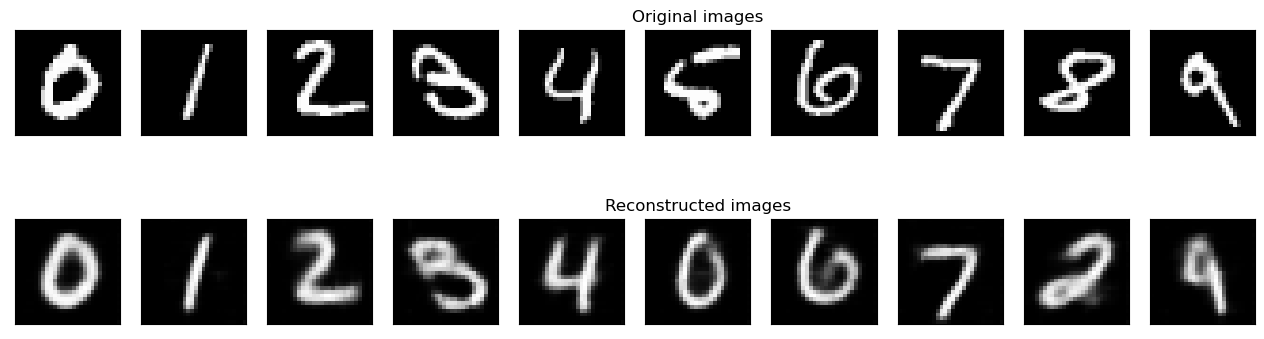


 EPOCH 39/100 	 train loss 31.362 	 val loss 32.019


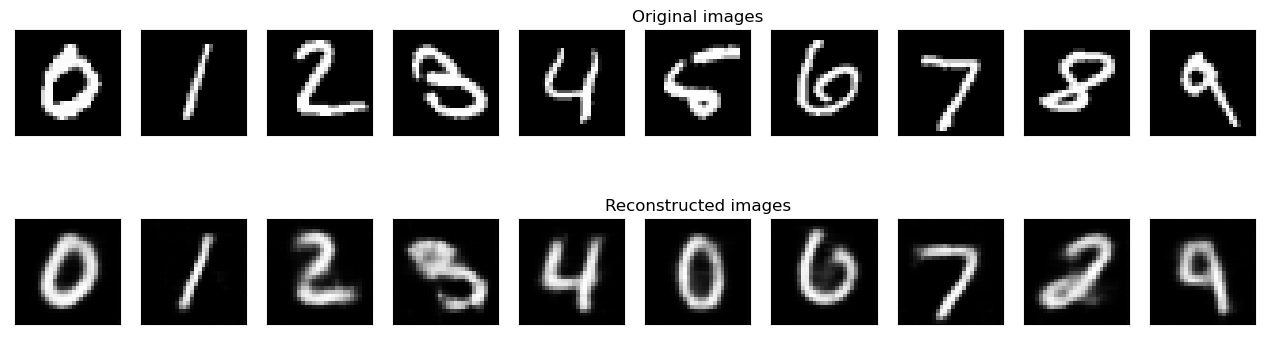


 EPOCH 40/100 	 train loss 31.350 	 val loss 31.952


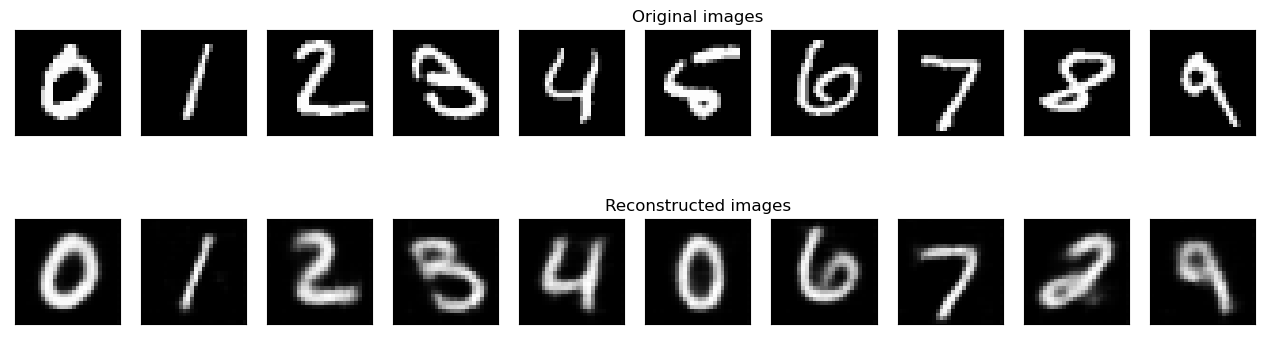


 EPOCH 41/100 	 train loss 31.367 	 val loss 31.935


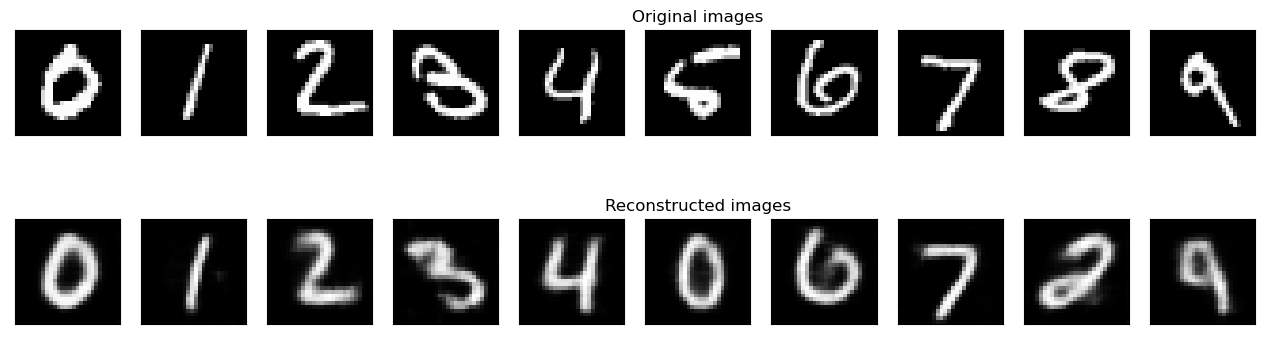


 EPOCH 42/100 	 train loss 31.377 	 val loss 32.032


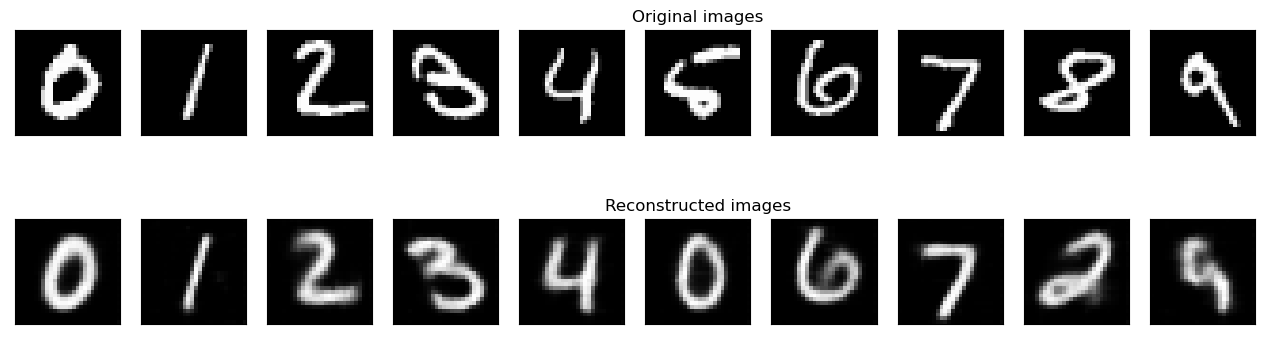


 EPOCH 43/100 	 train loss 31.335 	 val loss 32.007


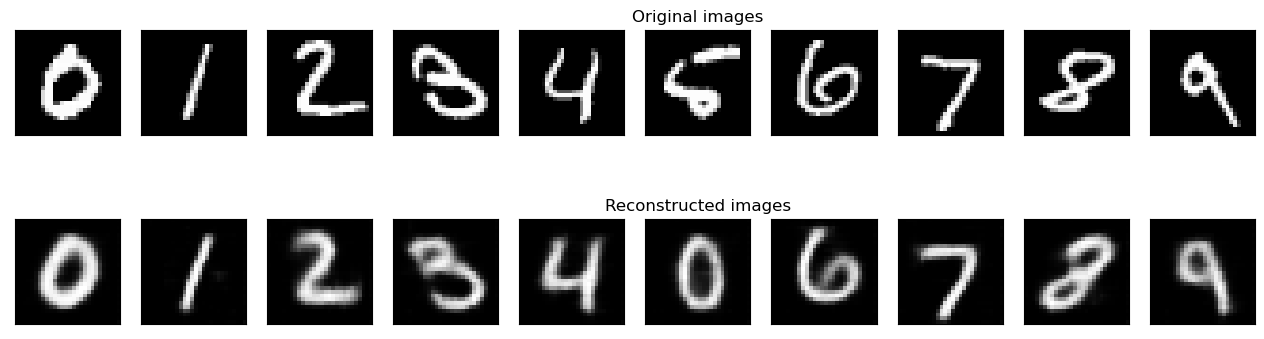


 EPOCH 44/100 	 train loss 31.311 	 val loss 31.947


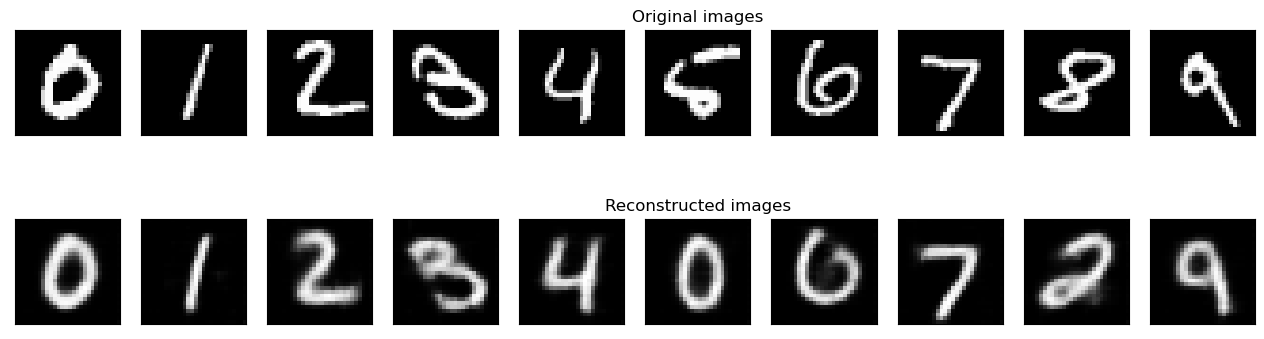


 EPOCH 45/100 	 train loss 31.339 	 val loss 31.947


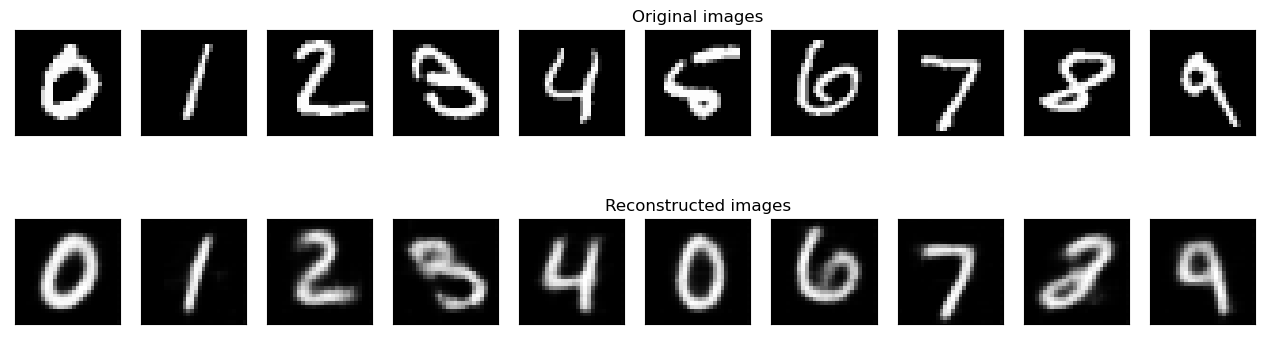


 EPOCH 46/100 	 train loss 31.316 	 val loss 31.902


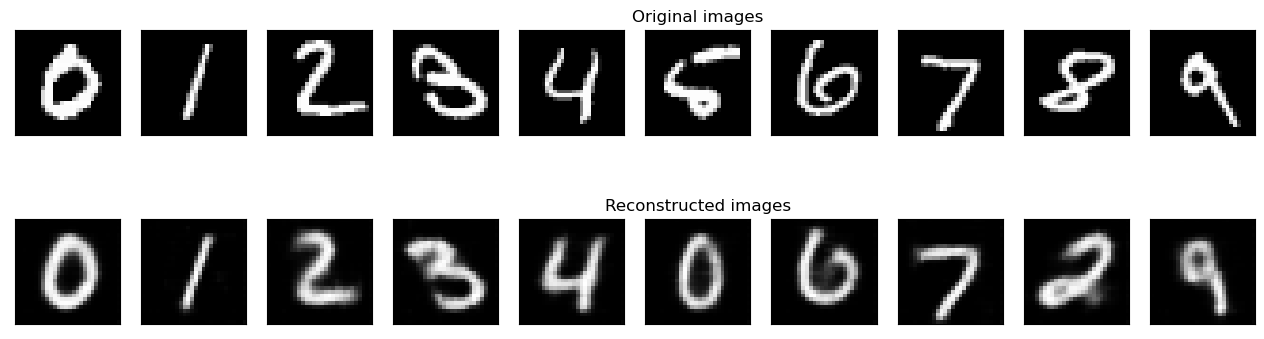


 EPOCH 47/100 	 train loss 31.307 	 val loss 31.908


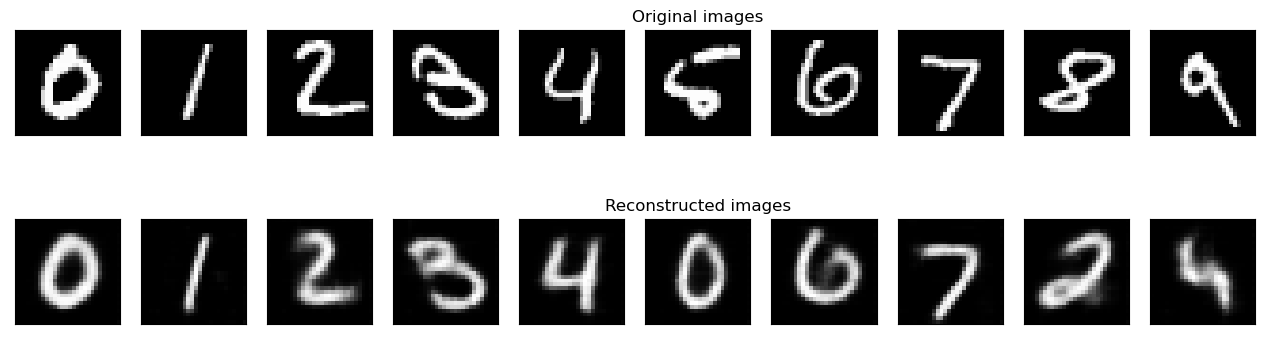


 EPOCH 48/100 	 train loss 31.294 	 val loss 32.003


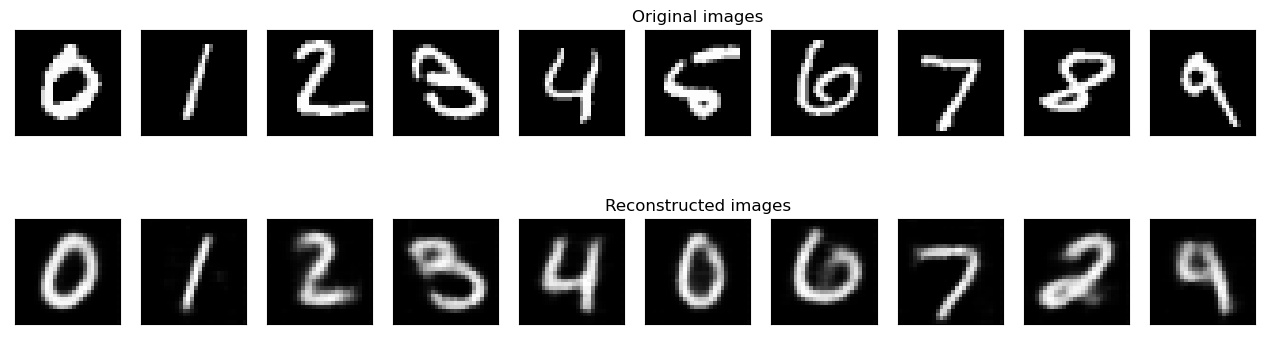


 EPOCH 49/100 	 train loss 31.325 	 val loss 32.024


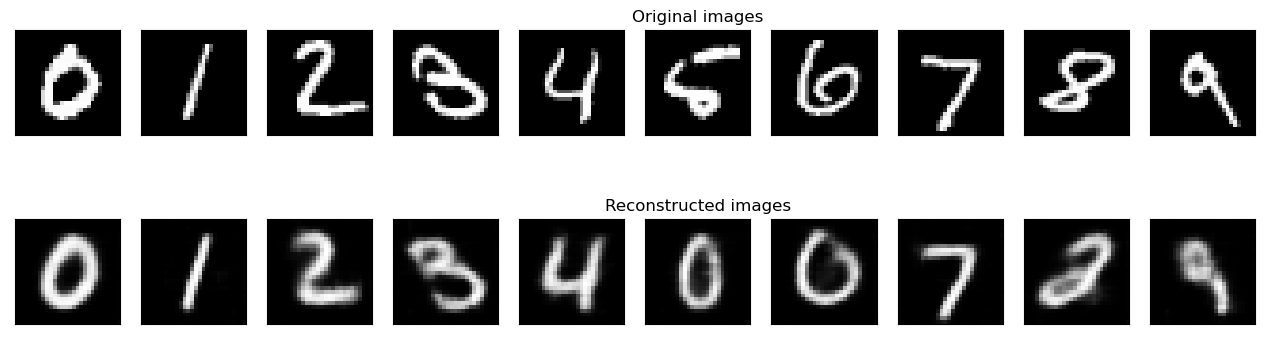


 EPOCH 50/100 	 train loss 31.290 	 val loss 31.897


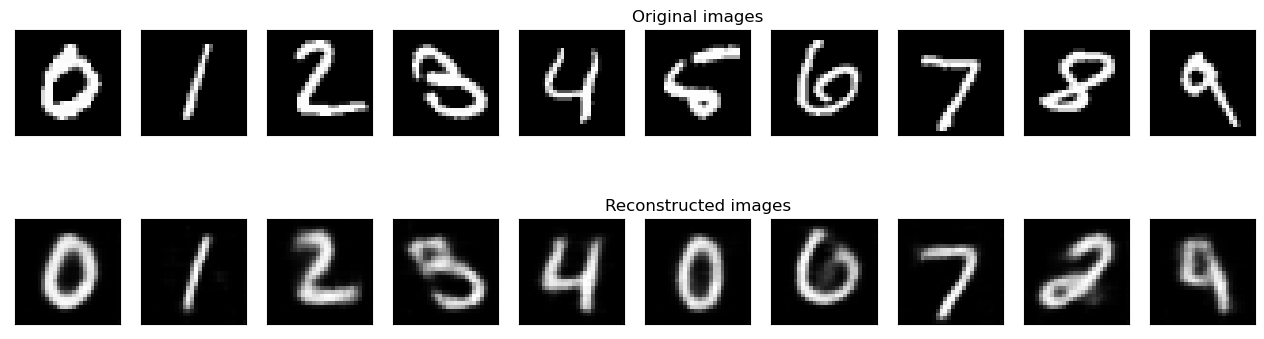


 EPOCH 51/100 	 train loss 31.267 	 val loss 31.872


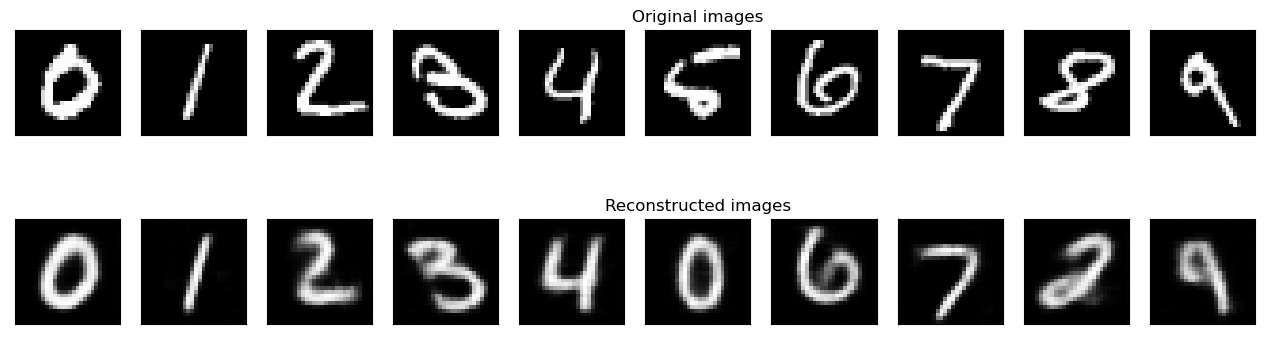


 EPOCH 52/100 	 train loss 31.267 	 val loss 31.973


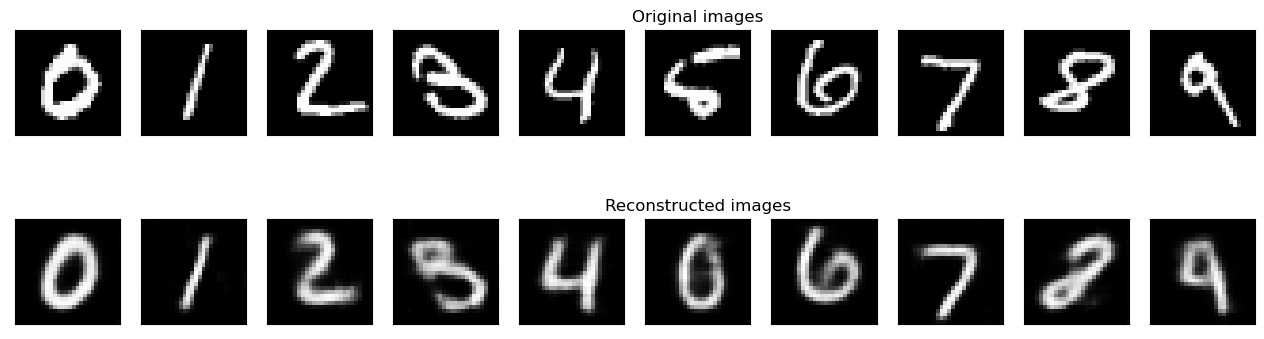


 EPOCH 53/100 	 train loss 31.283 	 val loss 31.857


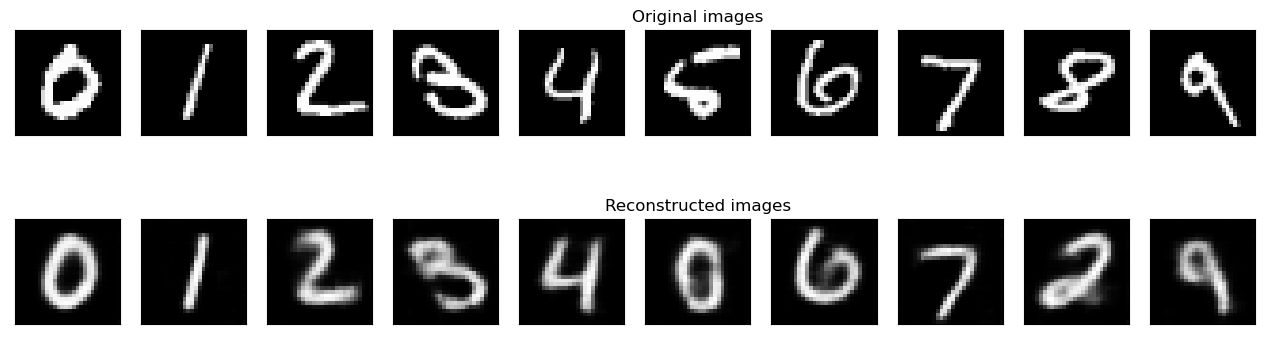


 EPOCH 54/100 	 train loss 31.241 	 val loss 31.861


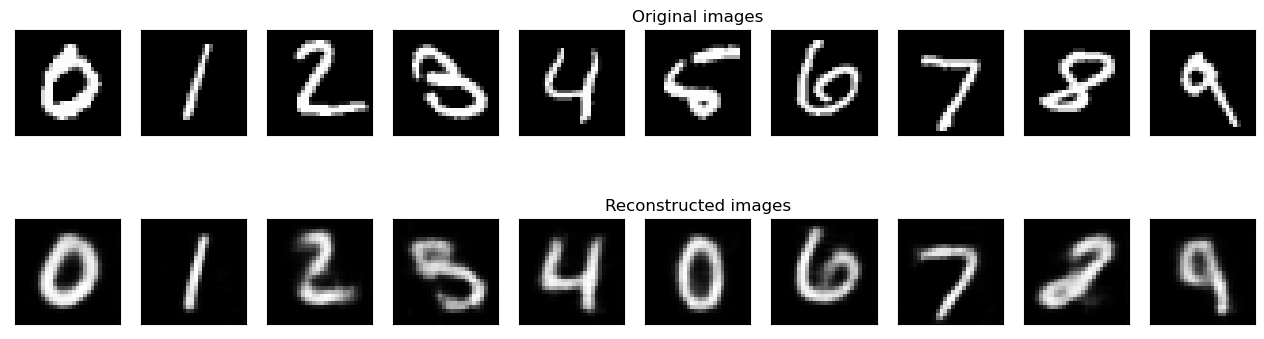


 EPOCH 55/100 	 train loss 31.264 	 val loss 31.931


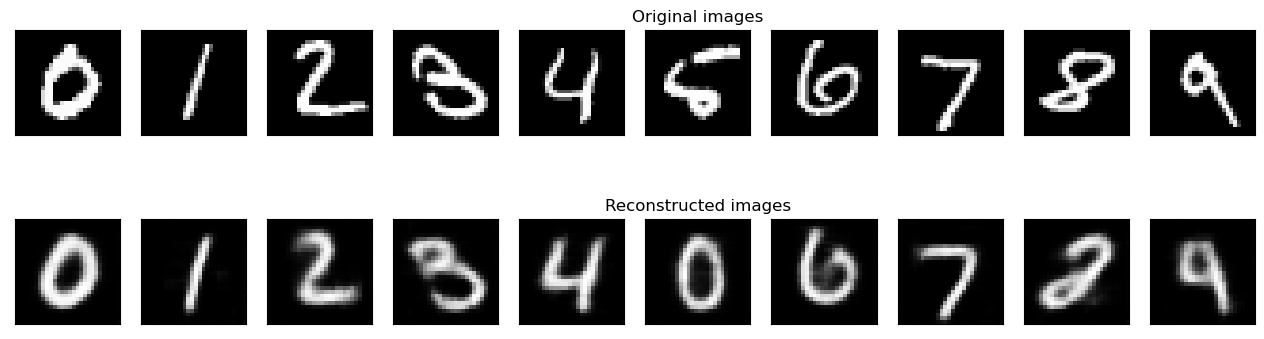


 EPOCH 56/100 	 train loss 31.259 	 val loss 31.885


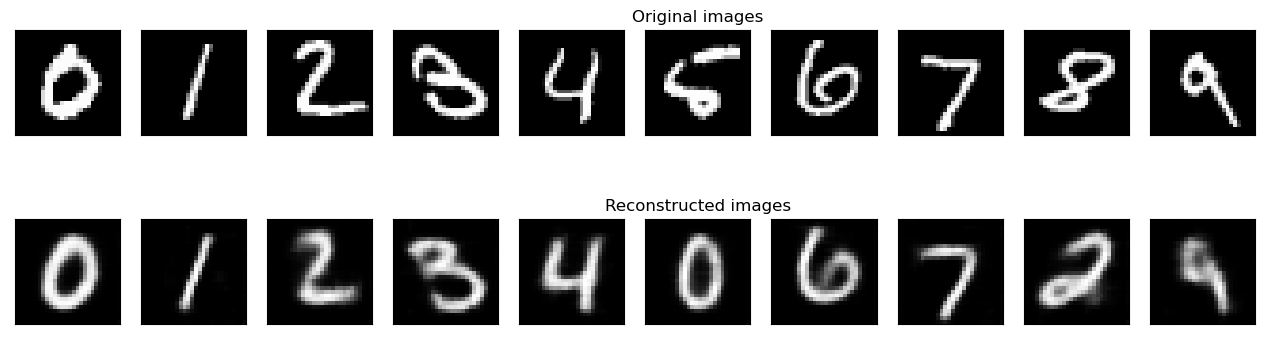


 EPOCH 57/100 	 train loss 31.204 	 val loss 32.048


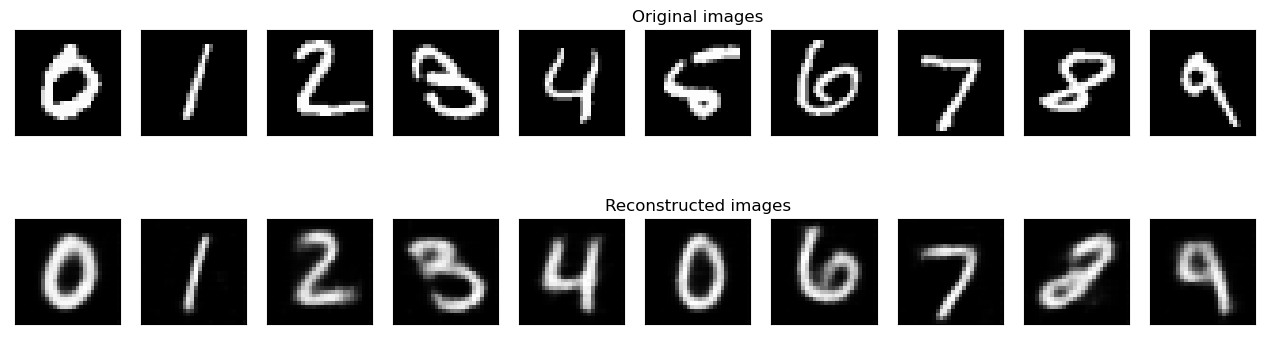


 EPOCH 58/100 	 train loss 31.233 	 val loss 31.815


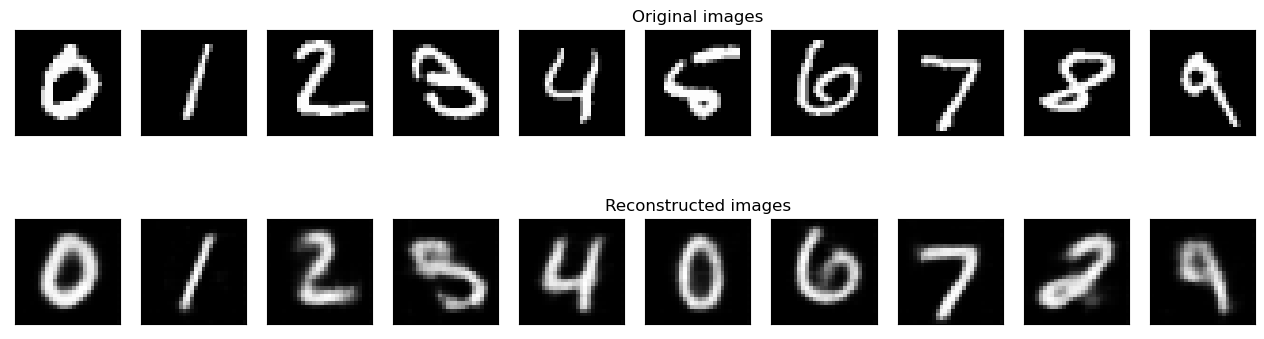


 EPOCH 59/100 	 train loss 31.214 	 val loss 31.895


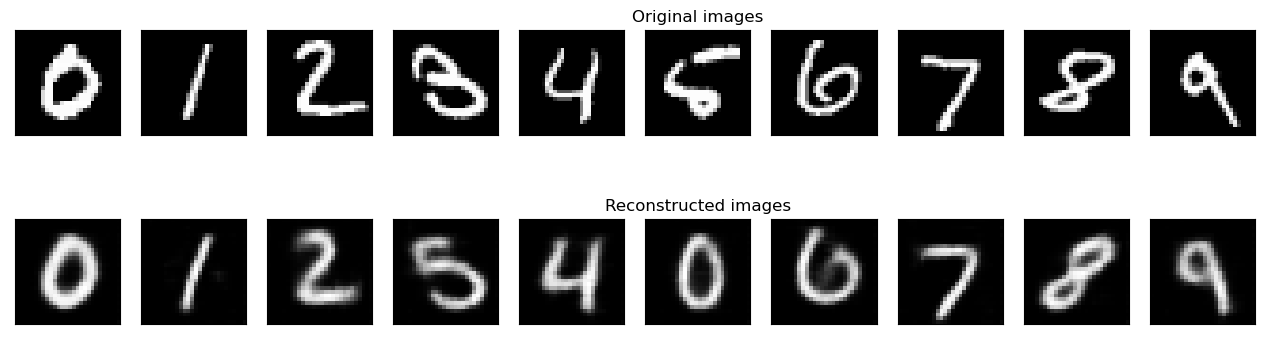


 EPOCH 60/100 	 train loss 31.242 	 val loss 31.938


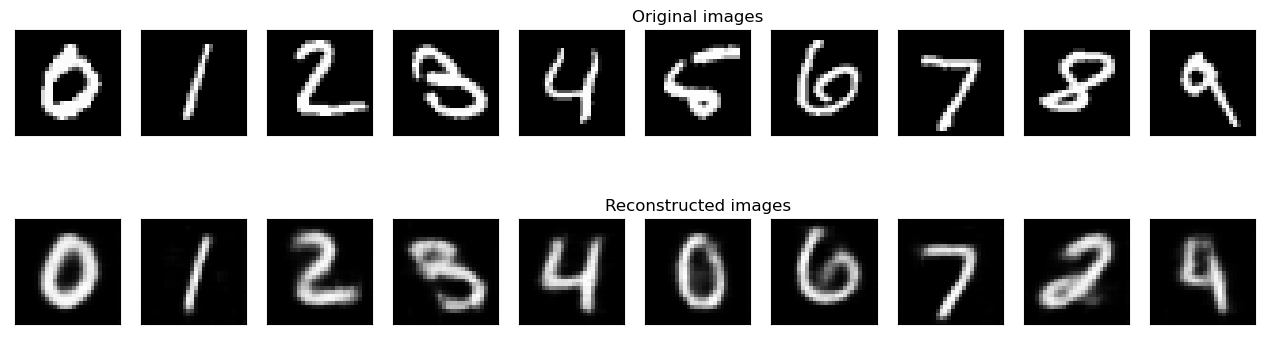


 EPOCH 61/100 	 train loss 31.232 	 val loss 31.925


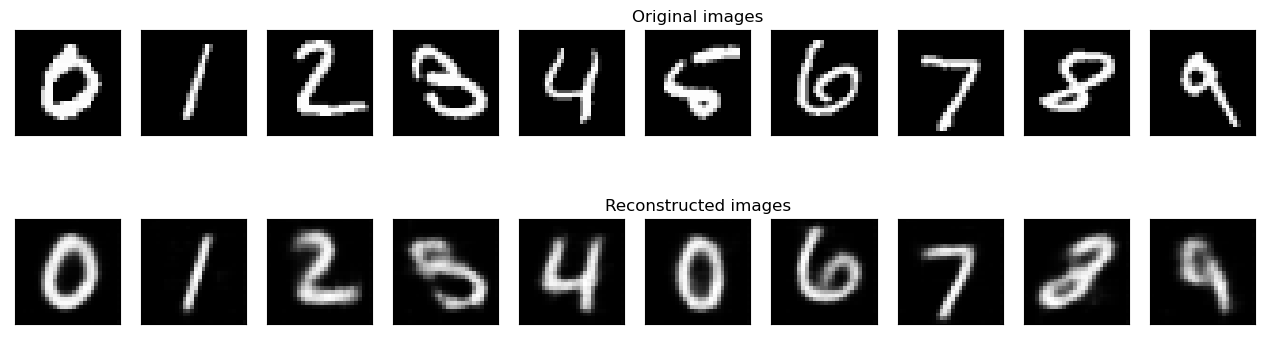


 EPOCH 62/100 	 train loss 31.200 	 val loss 31.888


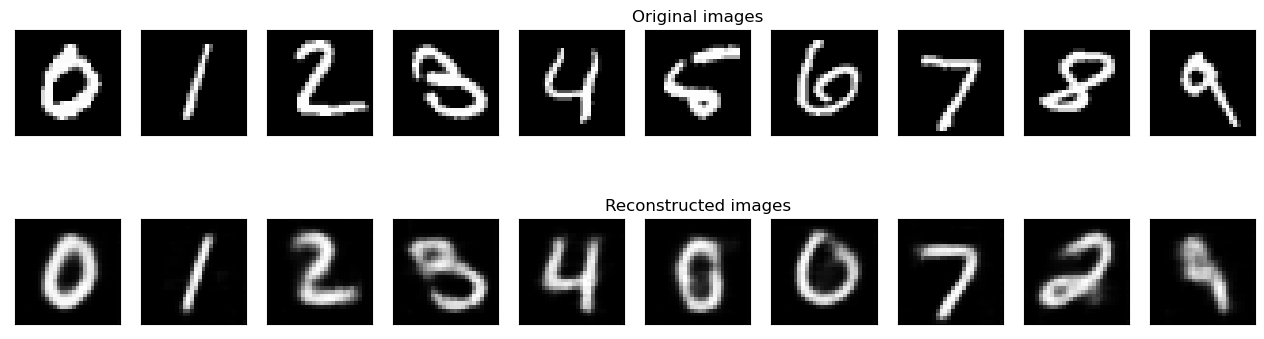


 EPOCH 63/100 	 train loss 31.216 	 val loss 31.843


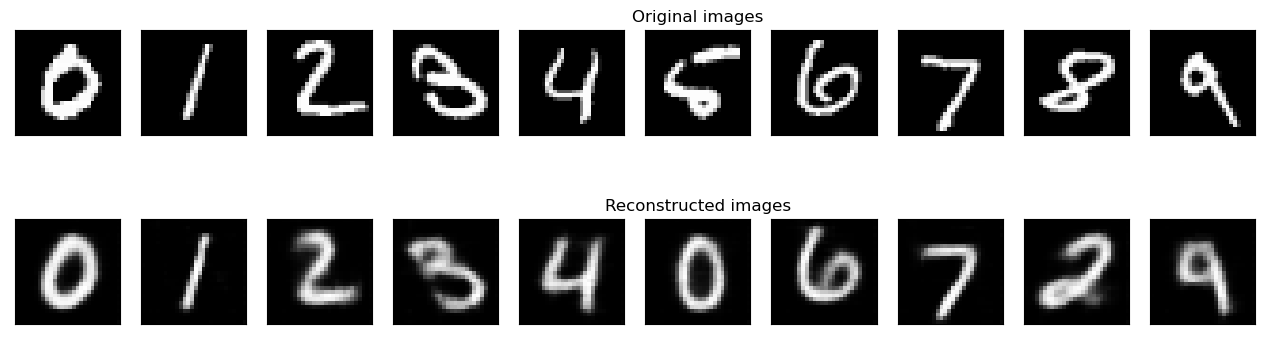


 EPOCH 64/100 	 train loss 31.199 	 val loss 31.789


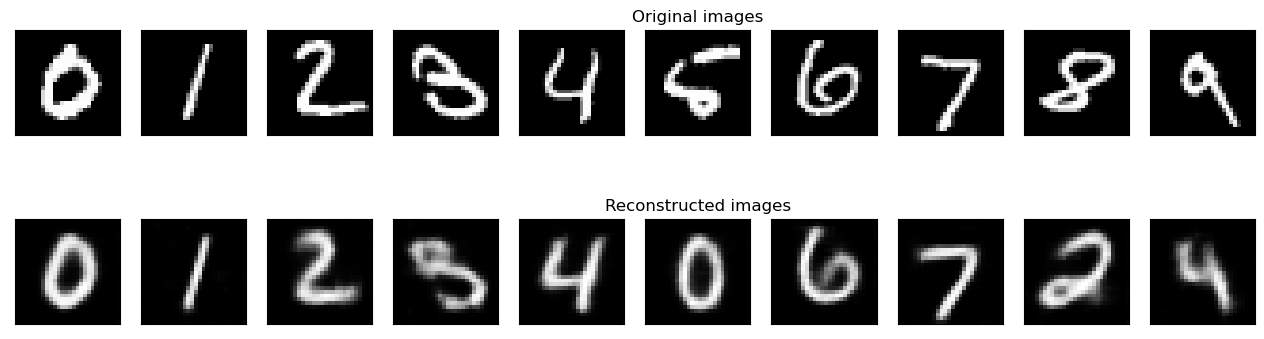


 EPOCH 65/100 	 train loss 31.182 	 val loss 31.879


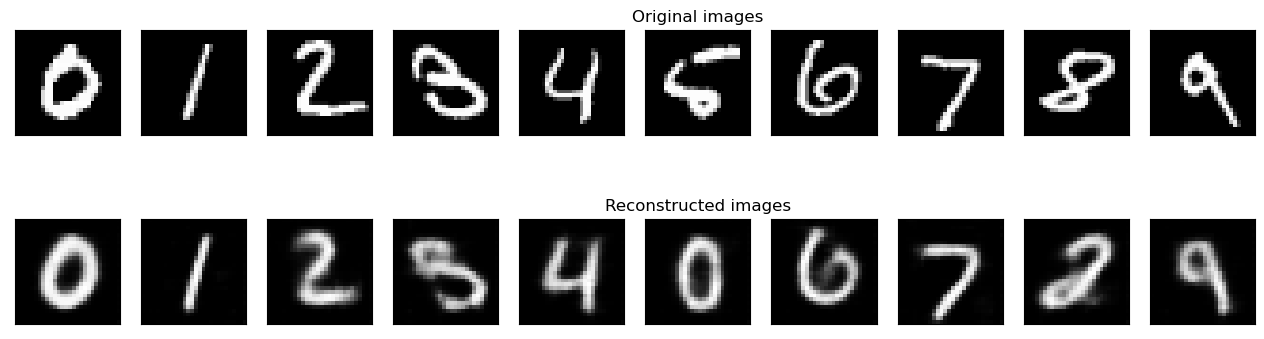


 EPOCH 66/100 	 train loss 31.196 	 val loss 31.907


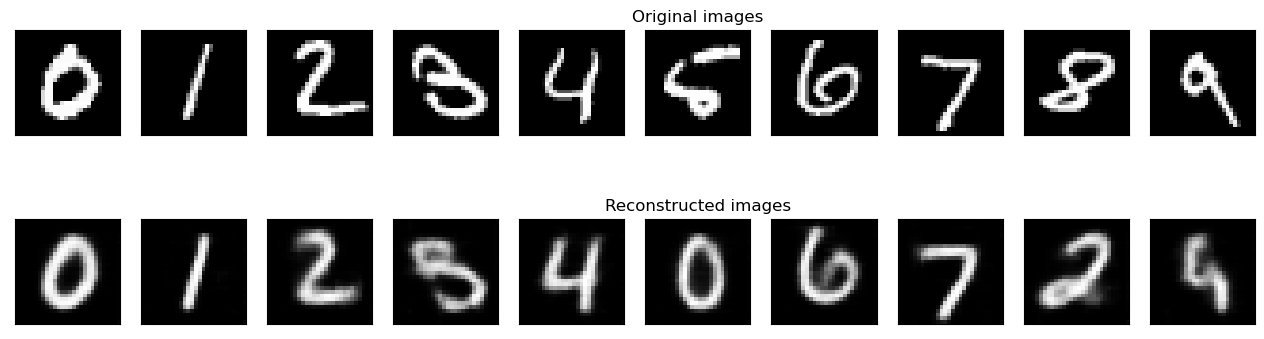


 EPOCH 67/100 	 train loss 31.172 	 val loss 31.889


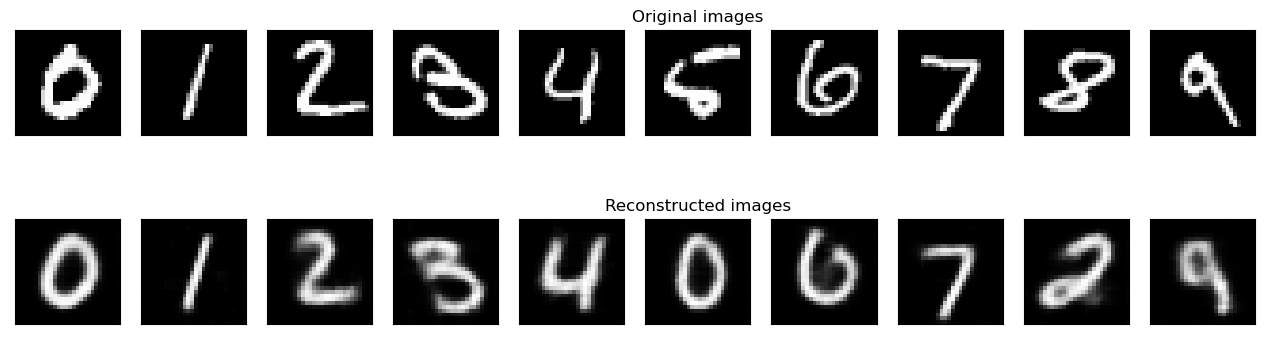


 EPOCH 68/100 	 train loss 31.179 	 val loss 31.938


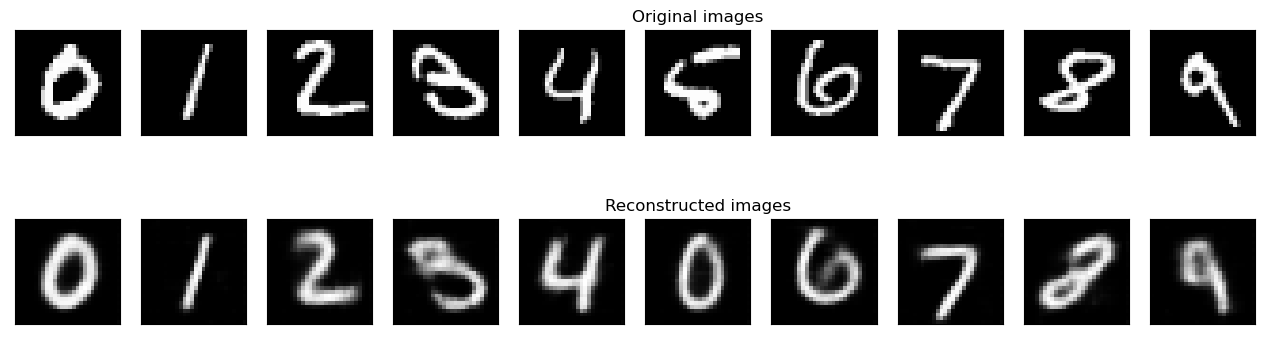


 EPOCH 69/100 	 train loss 31.169 	 val loss 31.803


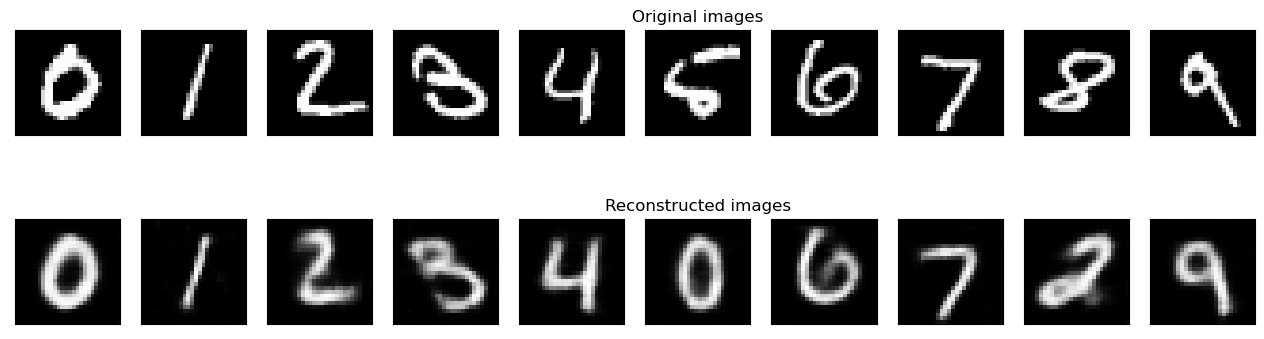


 EPOCH 70/100 	 train loss 31.165 	 val loss 31.791


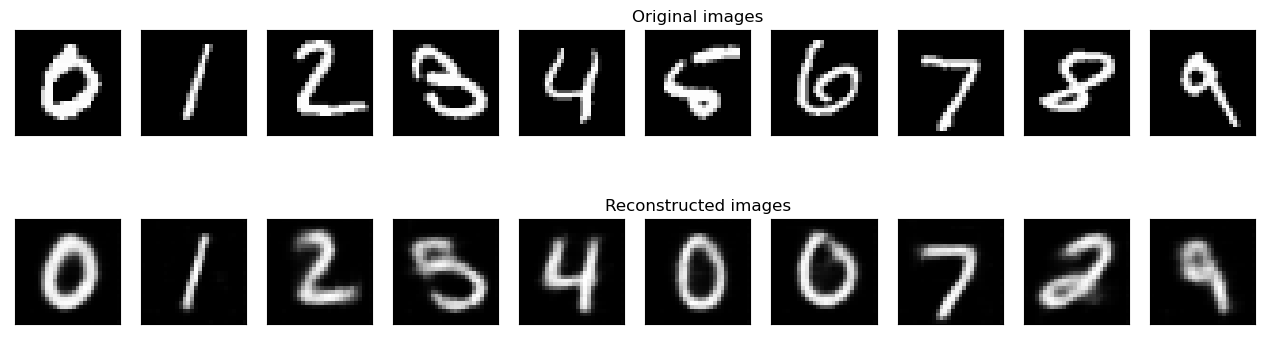


 EPOCH 71/100 	 train loss 31.149 	 val loss 31.824


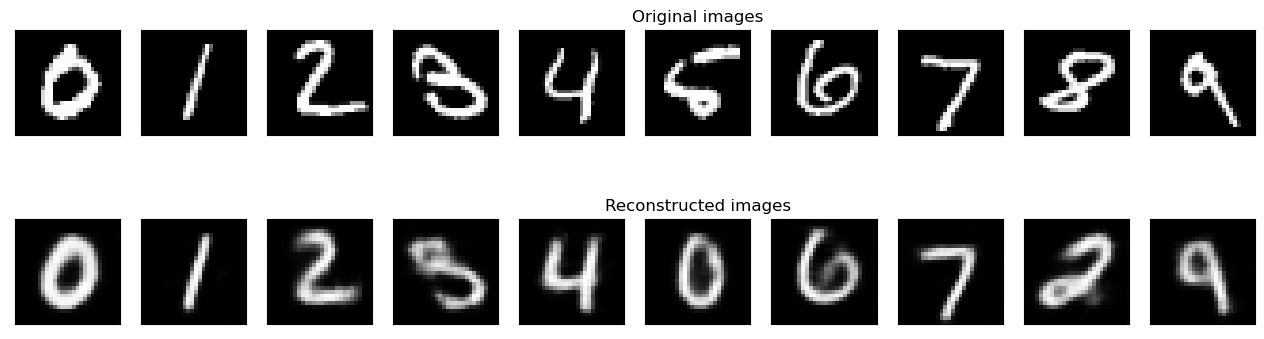


 EPOCH 72/100 	 train loss 31.129 	 val loss 31.815


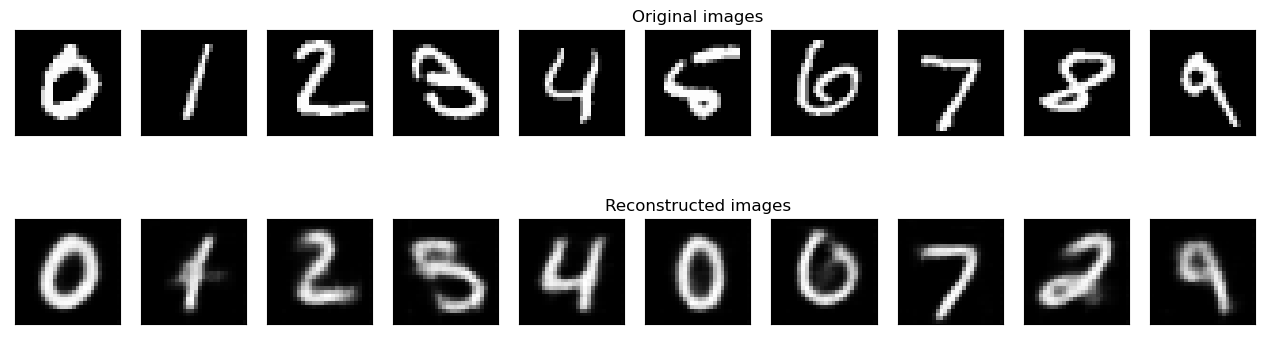


 EPOCH 73/100 	 train loss 31.140 	 val loss 31.813


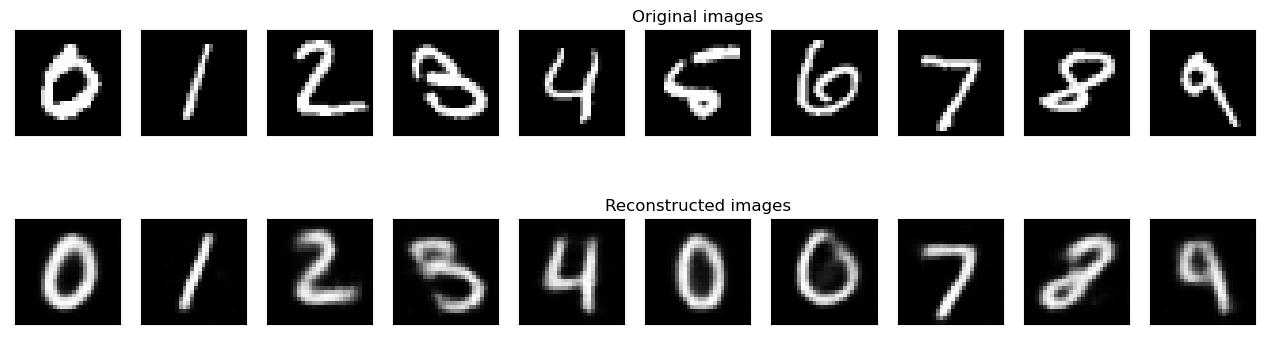


 EPOCH 74/100 	 train loss 31.124 	 val loss 31.818


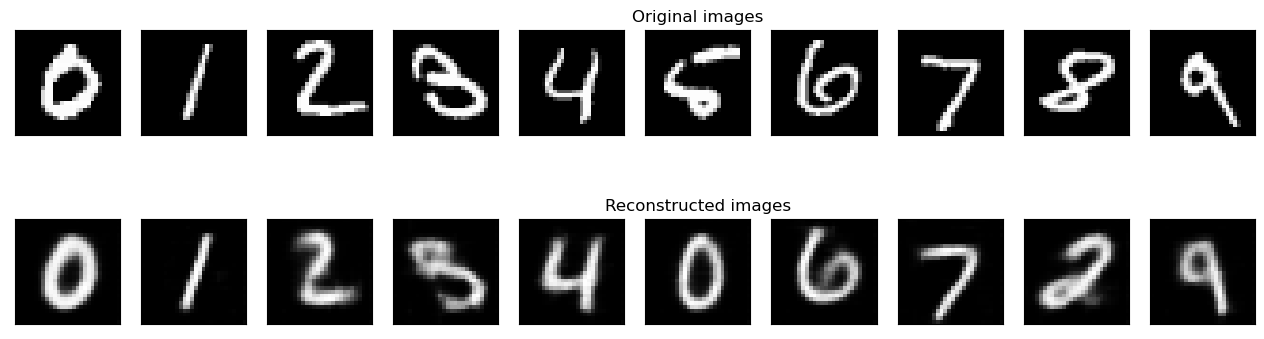


 EPOCH 75/100 	 train loss 31.133 	 val loss 31.872


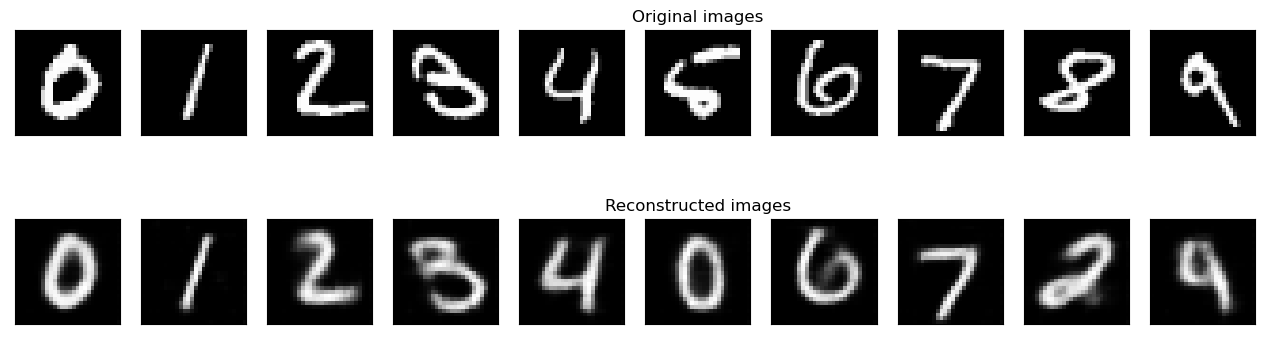


 EPOCH 76/100 	 train loss 31.114 	 val loss 31.819


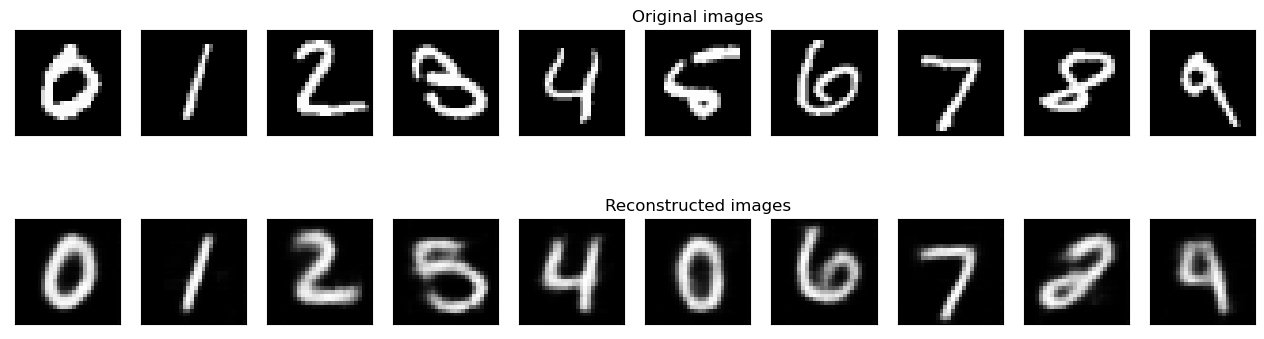


 EPOCH 77/100 	 train loss 31.112 	 val loss 31.834


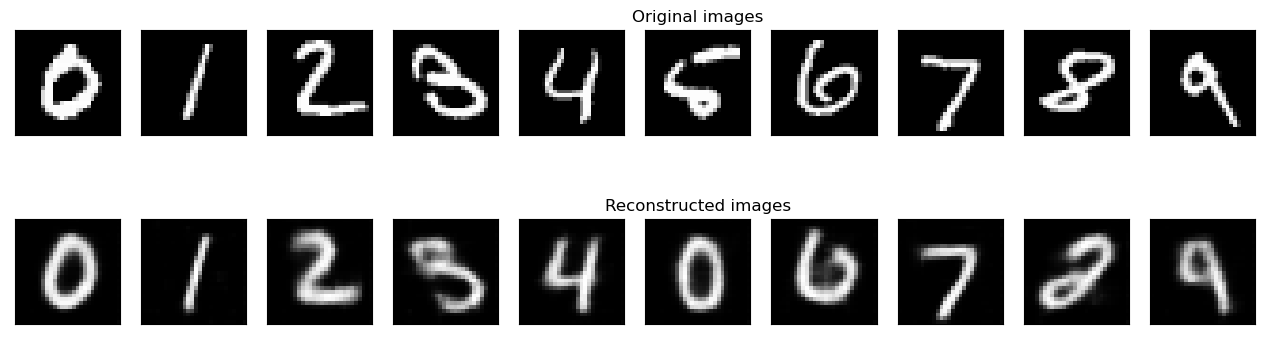


 EPOCH 78/100 	 train loss 31.122 	 val loss 31.835


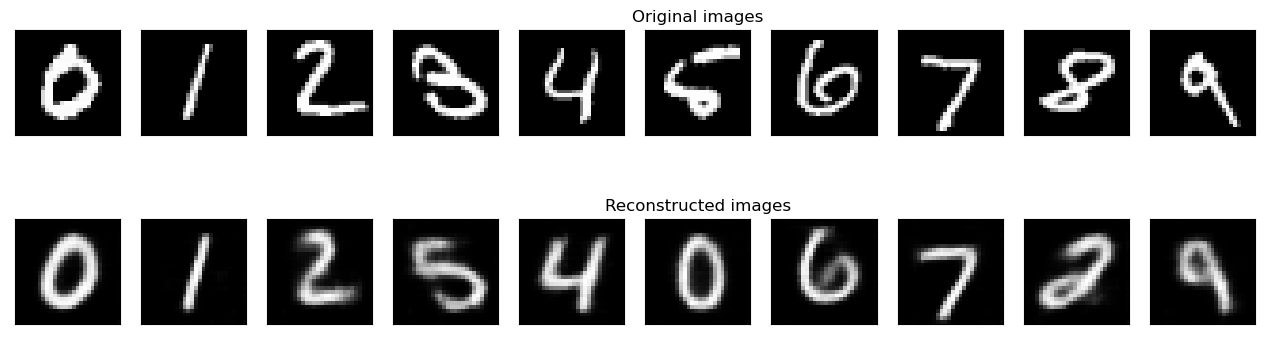


 EPOCH 79/100 	 train loss 31.089 	 val loss 31.816


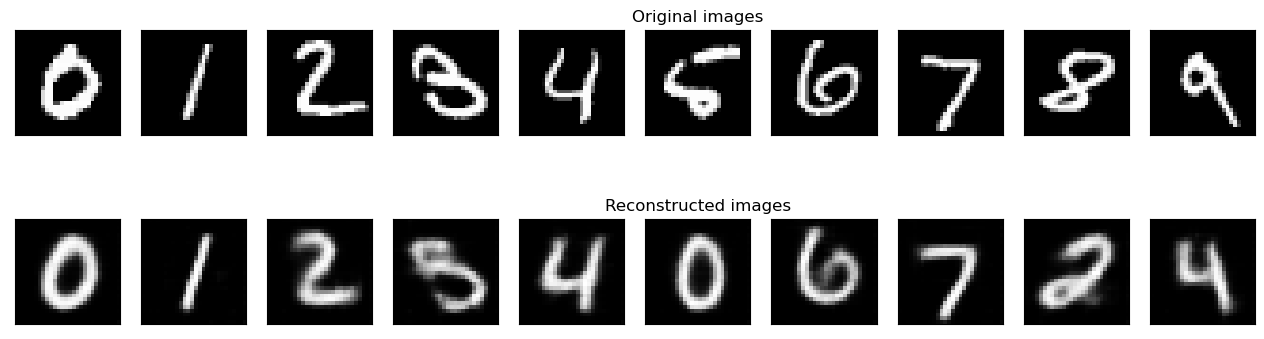


 EPOCH 80/100 	 train loss 31.115 	 val loss 31.819


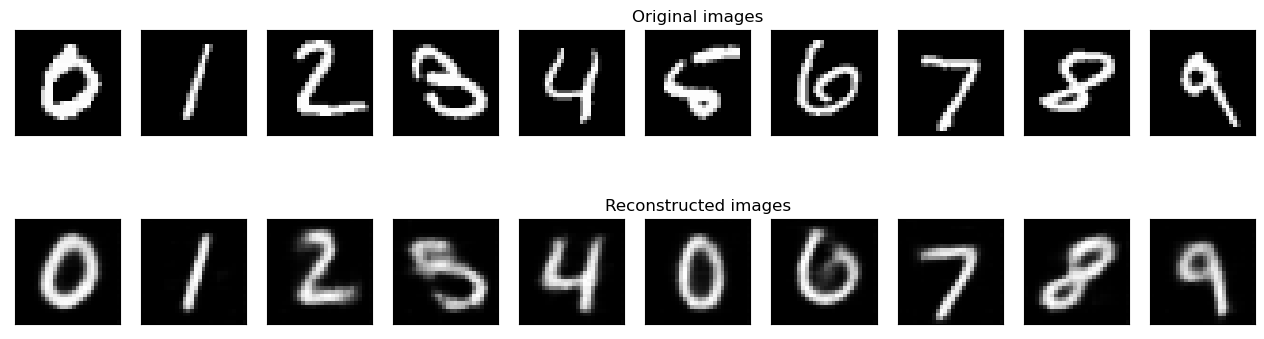


 EPOCH 81/100 	 train loss 31.085 	 val loss 31.814


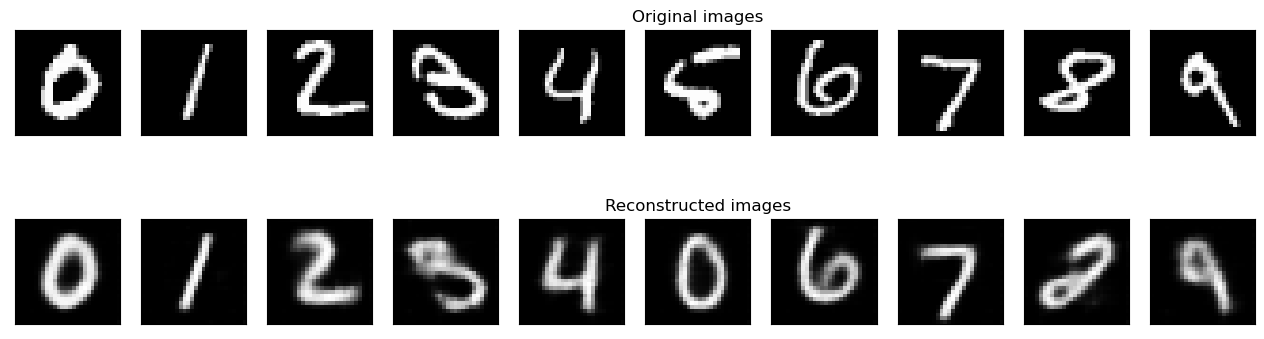


 EPOCH 82/100 	 train loss 31.089 	 val loss 31.870


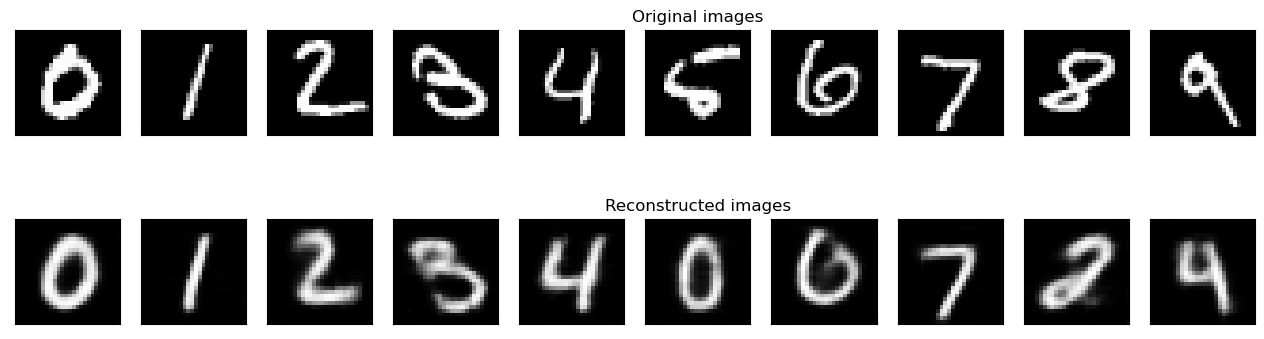


 EPOCH 83/100 	 train loss 31.101 	 val loss 31.794


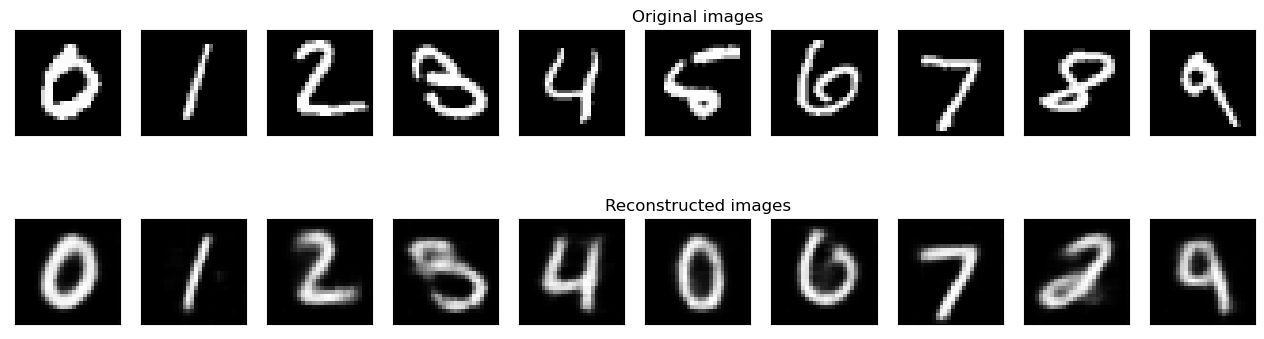


 EPOCH 84/100 	 train loss 31.068 	 val loss 31.775


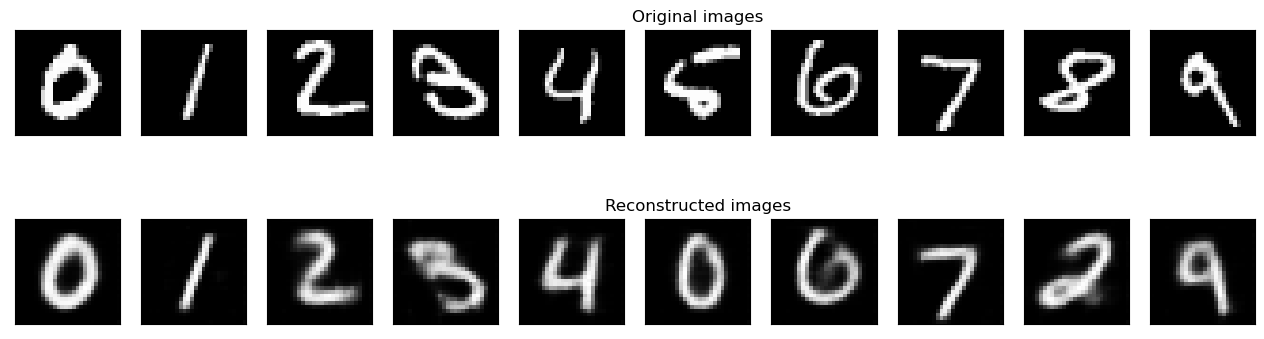


 EPOCH 85/100 	 train loss 31.090 	 val loss 31.750


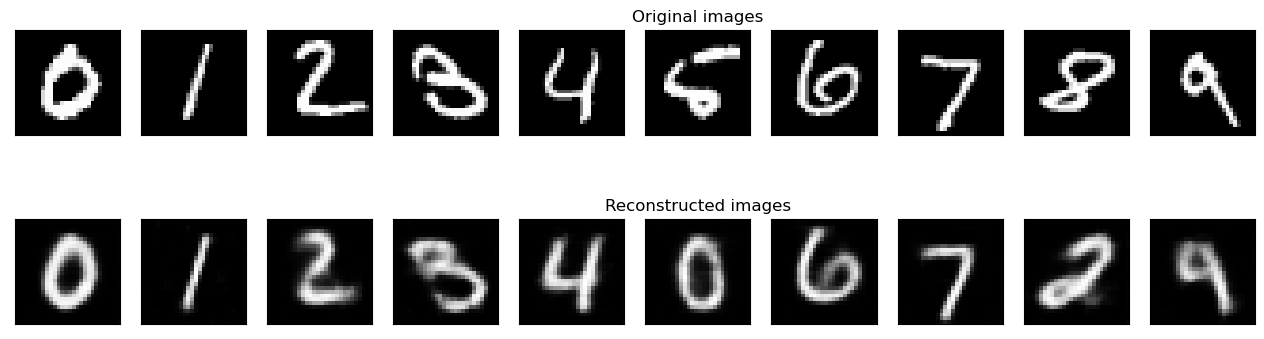


 EPOCH 86/100 	 train loss 31.050 	 val loss 31.770


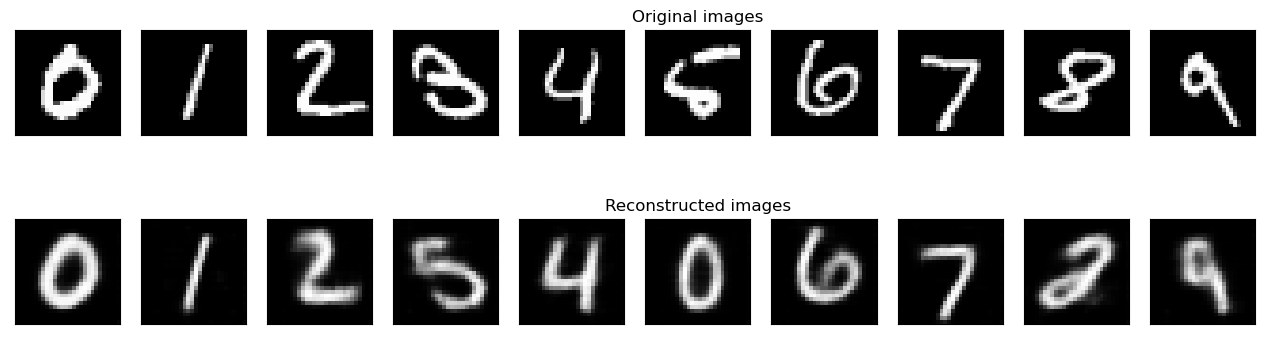


 EPOCH 87/100 	 train loss 31.055 	 val loss 31.828


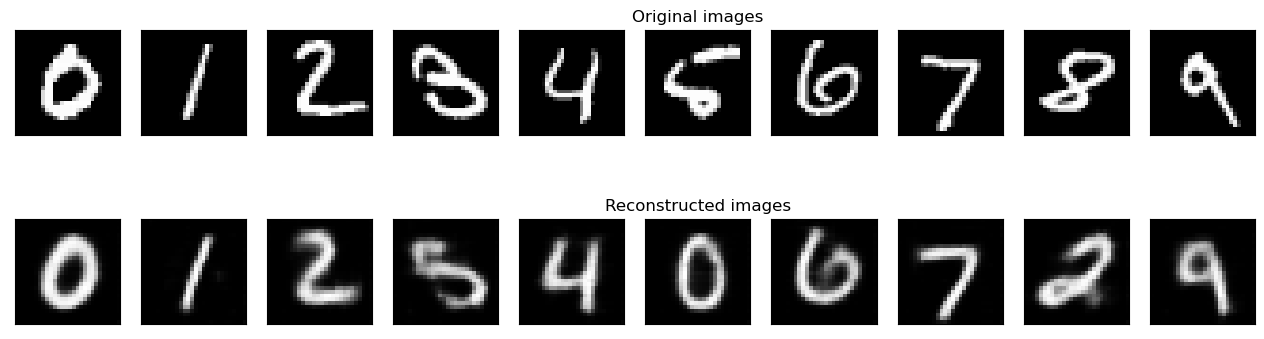


 EPOCH 88/100 	 train loss 31.065 	 val loss 31.851


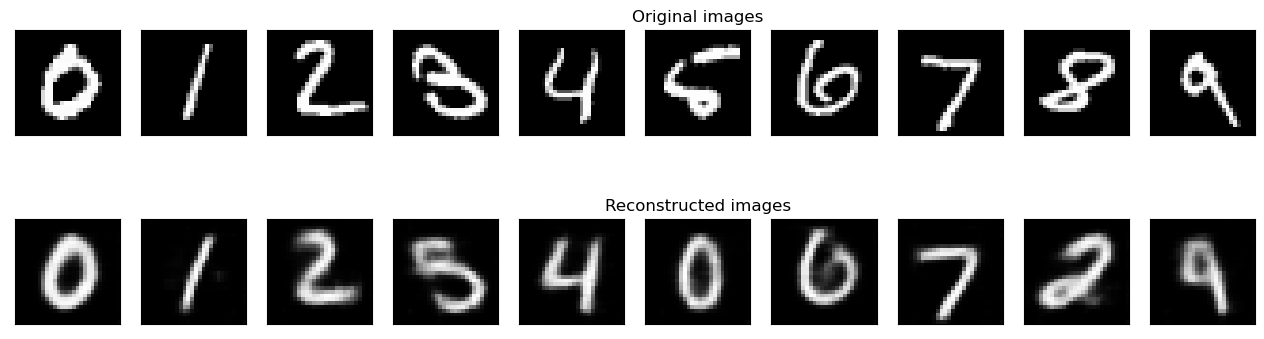


 EPOCH 89/100 	 train loss 31.049 	 val loss 31.799


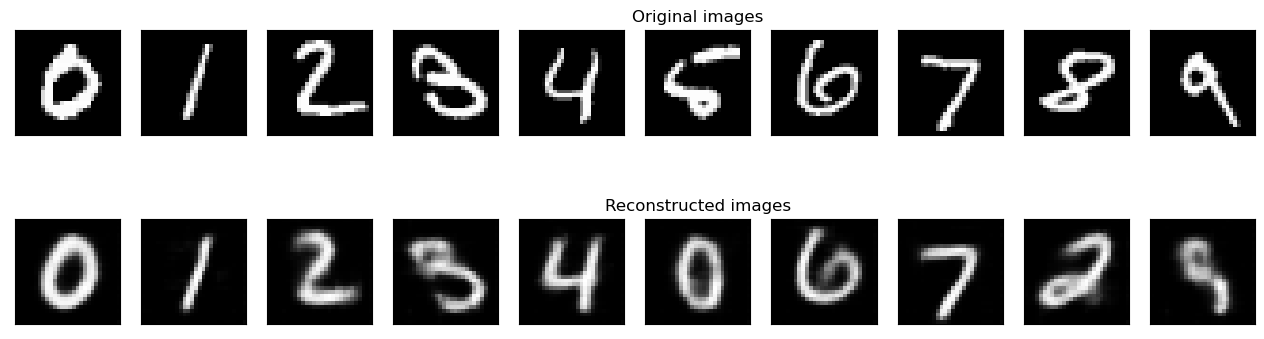


 EPOCH 90/100 	 train loss 31.048 	 val loss 31.914


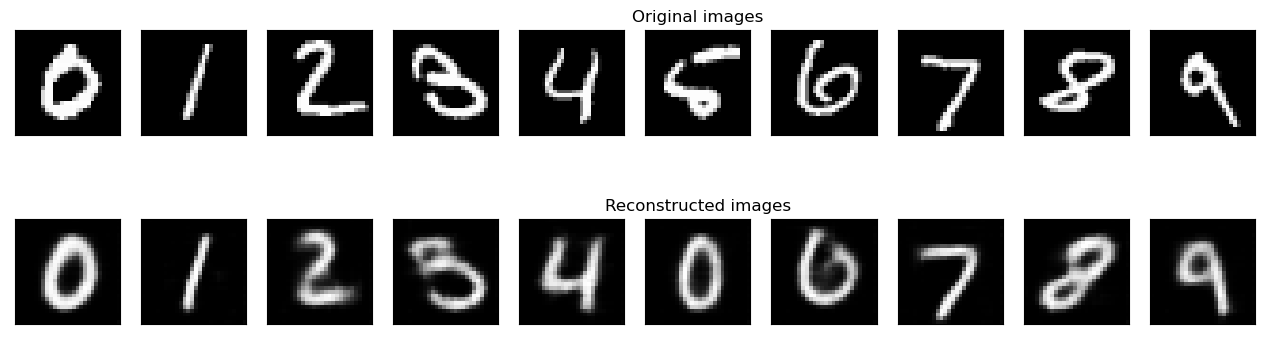


 EPOCH 91/100 	 train loss 31.060 	 val loss 31.800


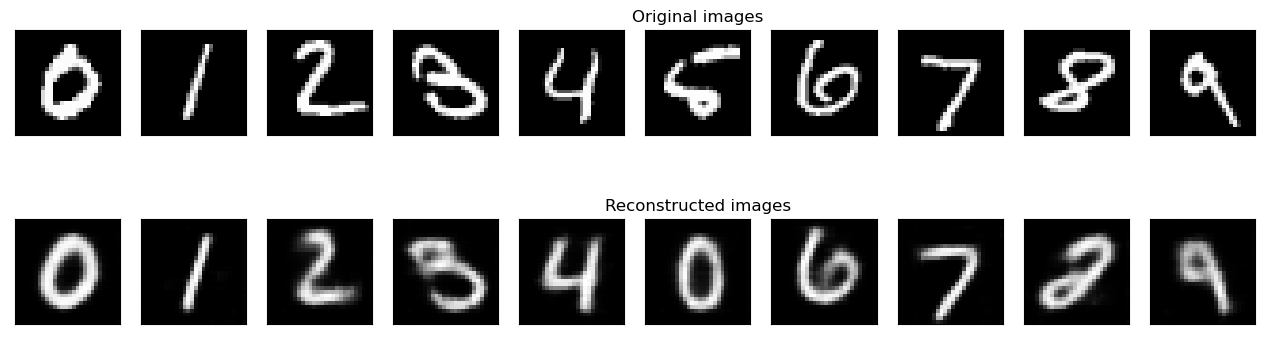


 EPOCH 92/100 	 train loss 31.019 	 val loss 31.753


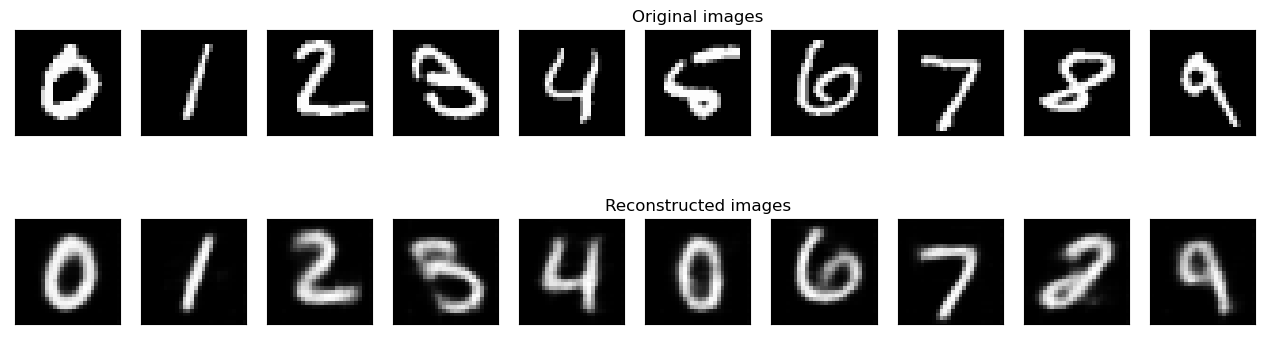


 EPOCH 93/100 	 train loss 31.041 	 val loss 31.783


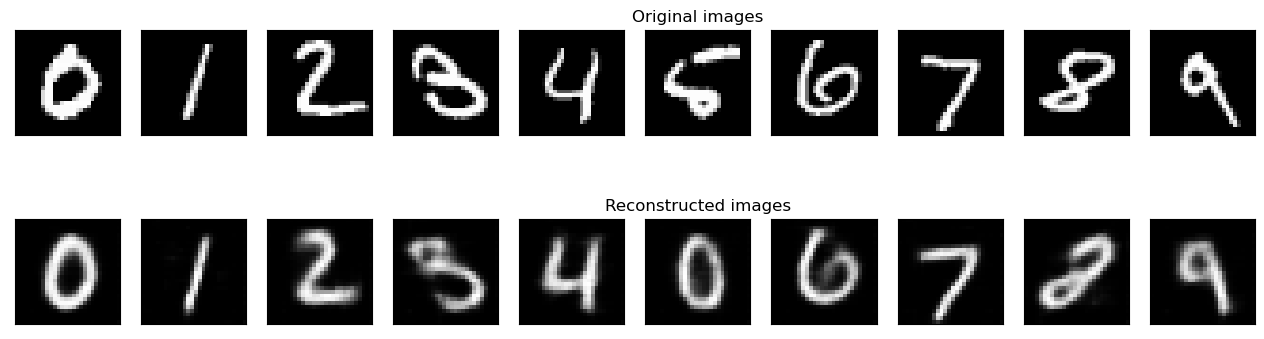


 EPOCH 94/100 	 train loss 31.033 	 val loss 31.799


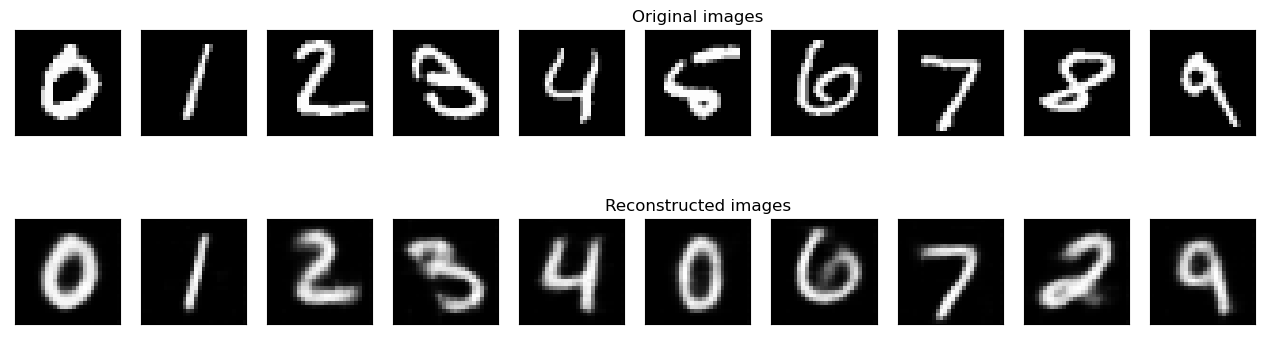


 EPOCH 95/100 	 train loss 31.032 	 val loss 31.726


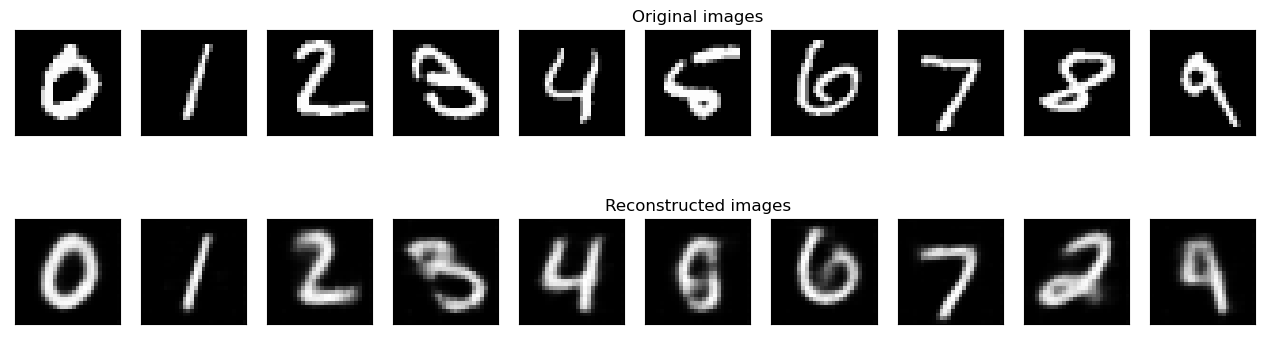


 EPOCH 96/100 	 train loss 31.035 	 val loss 31.758


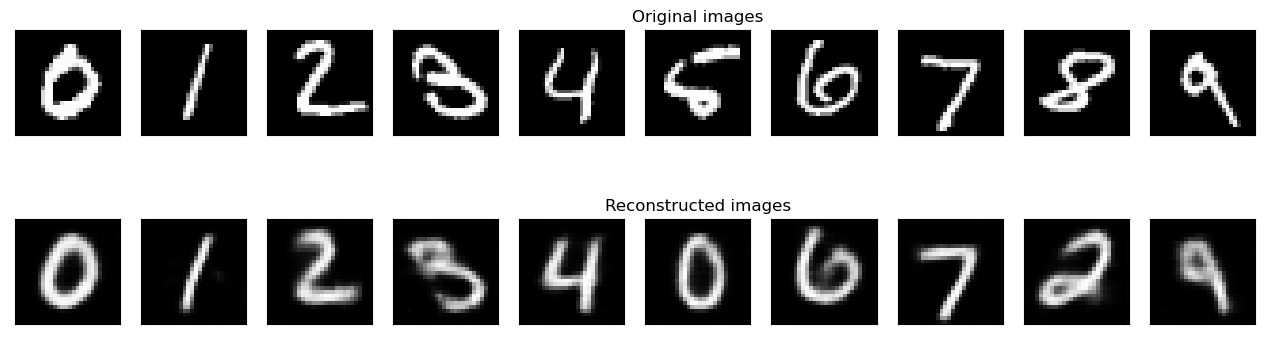


 EPOCH 97/100 	 train loss 31.002 	 val loss 31.735


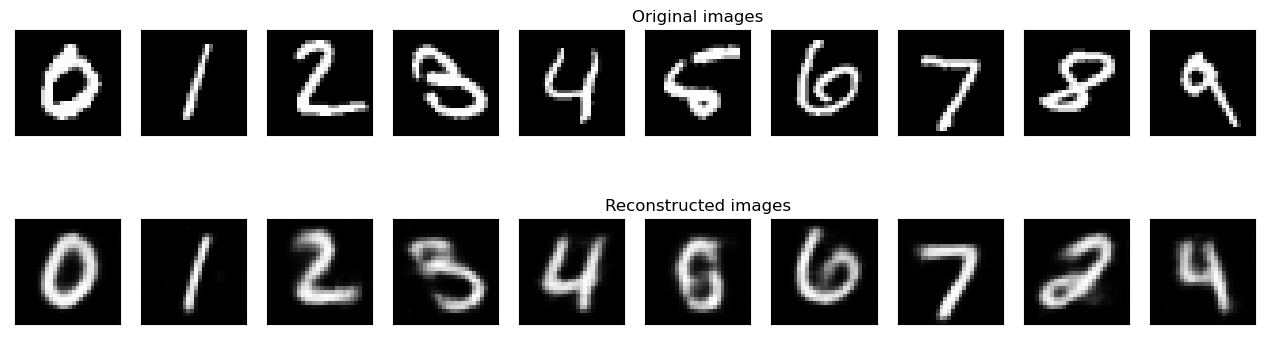


 EPOCH 98/100 	 train loss 30.995 	 val loss 31.767


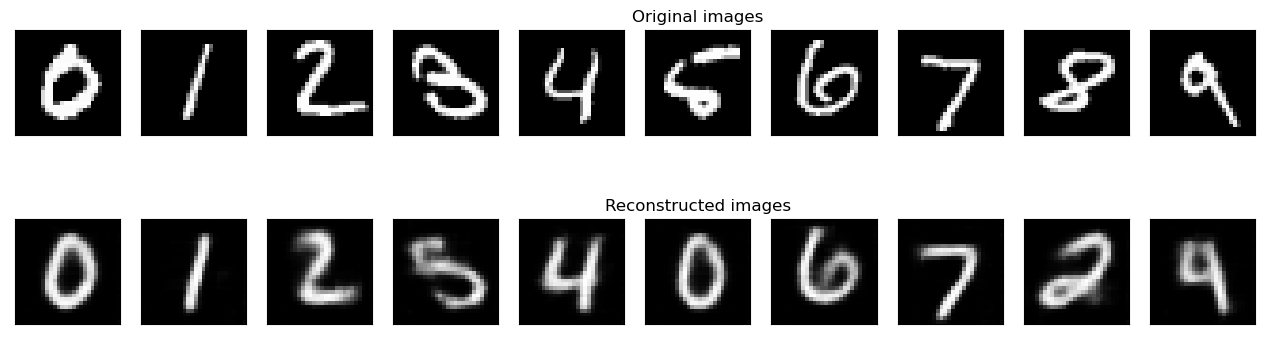


 EPOCH 99/100 	 train loss 30.992 	 val loss 31.801


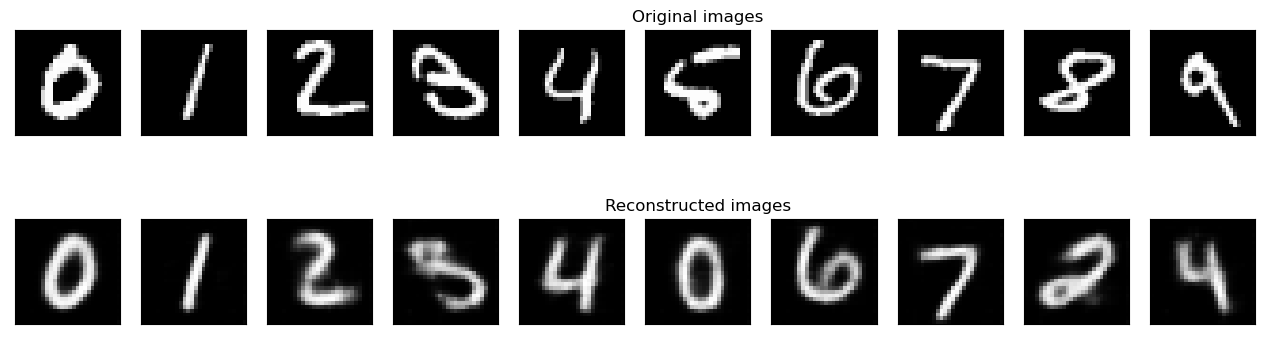


 EPOCH 100/100 	 train loss 30.978 	 val loss 31.720


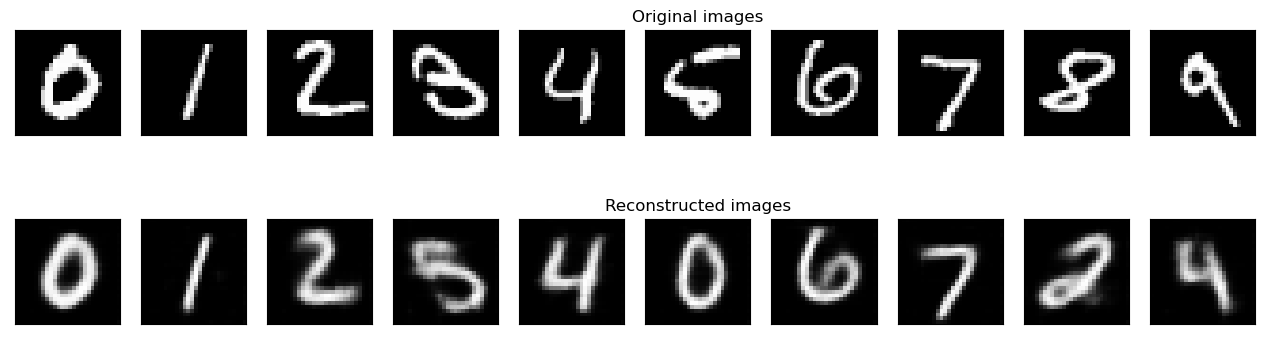

In [23]:
num_epochs = 100

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

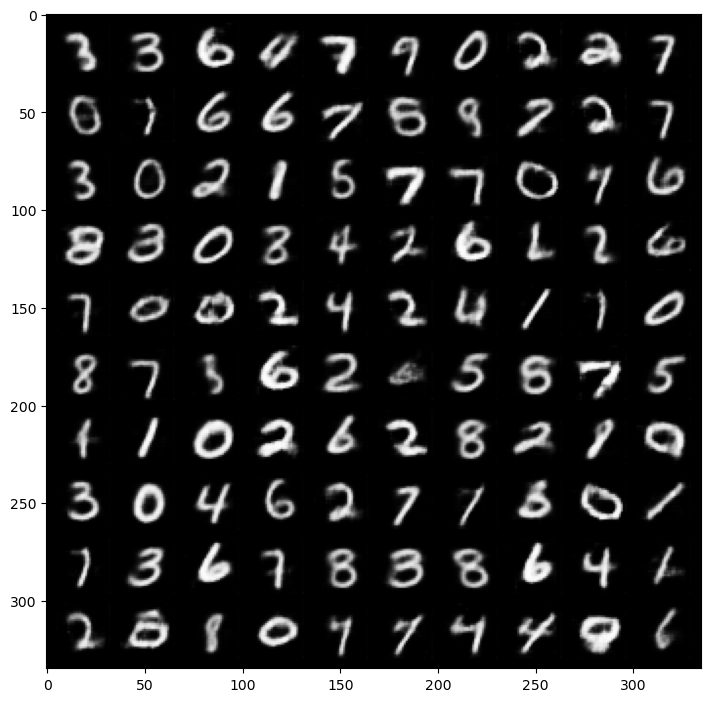

In [24]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

### Used resources: https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b 